In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00


In [ ]:
!pip install wordcloud

In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.7 MB/s eta 0:00:00


In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=61c4e01108b423d9b4da450bfdfcb3b95a7258f776217a0b280cbfc6706889ed
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer
nltk.download('stopwords')
import nltk
from nltk import word_tokenize, pos_tag

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
import os
import json
from collections import defaultdict
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
import re
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from wordcloud import WordCloud
import math
import torch.optim as optim
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt

## Data Preprocessing:

In [ ]:
directory_path = '/content/gdrive/MyDrive/healthbot'

med_data = defaultdict(list)

# Get a list of all files in the directory
all_files = os.listdir(directory_path)[1:]

# Filter for only .jsonl files
jsonl_files = [file for file in all_files if file.endswith('.jsonl')]


# Iterate through the .jsonl files and read their contents
for jsonl_file in jsonl_files:
    if jsonl_file == 'wants_antibiotics_for_a_cold.jsonl':
        continue
    file_path = os.path.join(directory_path, jsonl_file)
    with open(file_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            med_data['inputs'].append(data['prompt'])
            med_data['labels'].append(data['completion'])

In [ ]:
sym_dis_tr_df = pd.read_csv('/content/gdrive/MyDrive/healthbot/symptom-disease-train-dataset.csv')
sym_dis_te_df = pd.read_csv('/content/gdrive/MyDrive/healthbot/symptom-disease-test-dataset.csv')

#concat both test and train data
combined_sys_dis_df = pd.concat([sym_dis_tr_df, sym_dis_te_df], ignore_index=True)

# Define the mapping from old labels to new labels
label_mapping = {
    284: 'diabetes',
    285: 'diabetes',
    286: 'diabetes',
    287: 'diabetes',
    288: 'diabetes',
    289: 'diabetes',
    290: 'diabetes',
    291: 'diabetes',
    292: 'diabetes',
    376: 'fever',
    37: 'alzheimers',
    93: 'back pain',
    278: 'depression',
    294: 'diarrhea',
    401: 'gastrointestinal',
    404: 'gastrointestinal',
    403: 'gastrointestinal',
    234: 'common cold',
    447: 'heart attack',
    444: 'headaches',
    208: 'cough',
    191: 'chest pain'
}

# Apply the label mapping to the DataFrame
combined_sys_dis_df['labels'] = combined_sys_dis_df['label'].replace(label_mapping)
combined_sys_dis_df = combined_sys_dis_df.drop(columns=['label'])

# Define the labels you want to include
labels_to_include = [
    'diabetes', 'fever', 'alzheimers', 'back pain', 'depression',
    'diarrhea', 'gastrointestinal', 'common cold', 'heart attack',
    'headaches', 'cough', 'chest pain'
]

# Filter the DataFrame to include only rows with specified labels
filtered_sys_dis_df = combined_sys_dis_df[combined_sys_dis_df['labels'].isin(labels_to_include)]

print(len(filtered_sys_dis_df))
filtered_sys_dis_df.head()

528


,text,labels
22,"vomiting,breathlessness,sweating,chest_pain",heart attack
23,I've been feeling really run down lately. I've...,common cold
56,"continuous_sneezing,chills,fatigue,cough,high_...",common cold
92,Symptoms of high blood sugar or low blood suga...,diabetes
101,"vomiting,breathlessness,chest_pain",heart attack


In [ ]:
#changing the label names
replacement_mappings = {
    'diarhea': 'diarrhea',
    'Nasal Congestion': 'congestion',
    'gastrointestinal and respiratory': 'gastrointestinal'
}

replacement_mappings1 = {'headaches': 'headache'}

# Apply replacements
modified_labels = [replacement_mappings.get(label, label) for label in med_data['labels']]
modified_labels1 = [replacement_mappings1.get(label, label) for label in filtered_sys_dis_df['labels']]

In [ ]:
del med_data['labels']

In [ ]:
med_data['labels'] = modified_labels

In [ ]:
#upadting the med data with new labels
#med_data['labels'] = modified_labels
med_data['inputs'].extend(filtered_sys_dis_df['text'])
med_data['labels'].extend(modified_labels1)

In [ ]:
set(med_data['labels'])

{'alzheimers',
 'back pain',
 'chest pain',
 'common cold',
 'congestion',
 'cough',
 'depression',
 'diabetes',
 'diarrhea',
 'fever',
 'gastrointestinal',
 'headache',
 'heart attack',
 'rash',
 'urinary tract infection',
 'weakness'}

In [ ]:
print(len(med_data['inputs']))

994


In [ ]:
path = "/content/gdrive/MyDrive/healthbot/"
file_name = 'input_queries.pkl'
with open(path + file_name , 'rb') as file:
    input_queries = pickle.load(file)

In [ ]:
dfs = []

# Iterate through the dictionary and create DataFrames for each disease
for disease, queries in input_queries.items():
    df_temp = pd.DataFrame({'inputs': queries, 'labels': disease})
    dfs.append(df_temp)

# Concatenate the DataFrames to create the final DataFrame
df2 = pd.concat(dfs, ignore_index=True)
df2.head()

,inputs,labels
0,What are the early symptoms of Alzheimer's dis...,alzheimers
1,Can you explain the stages of Alzheimer's dise...,alzheimers
2,How can I soothe skin irritation from a rash d...,alzheimers
3,Are there any breakthroughs in Alzheimer's res...,alzheimers
4,Can meditation help manage the symptoms of Alz...,alzheimers


In [ ]:
df2.shape

(1573, 2)

In [ ]:
med_data['inputs'].extend(df2['inputs'])
med_data['labels'].extend(df2['labels'])

In [ ]:
#unique diseases
set(med_data['labels'])

{'Nasal Congestion',
 'alzheimers',
 'back pain',
 'chest pain',
 'common cold',
 'congestion',
 'cough',
 'depression',
 'diabetes',
 'diarhea',
 'diarrhea',
 'fever',
 'gastrointestinal',
 'gastrointestinal and respiratory',
 'headache',
 'heart attack',
 'rash',
 'urinary tract infection',
 'weakness'}

In [ ]:
path = "/content/gdrive/MyDrive/healthbot/"
file_name = 'ques_resp.pkl'
with open(path + file_name , 'rb') as file:
    ques_resp = pickle.load(file)

file_name1 = 'ques_resp2.pkl'
with open(path + file_name1 , 'rb') as file:
    ques_resp2 = pickle.load(file)

In [ ]:
med_data['inputs'].extend(ques_resp['queries'])
med_data['inputs'].extend(ques_resp2['queries'])
med_data['labels'].extend(ques_resp['labels'])
med_data['labels'].extend(ques_resp2['labels'])

In [ ]:
#creating a .pkl for the updated data
path = "/content/gdrive/MyDrive/healthbot/"
file_name = 'med_data_all.pkl'
with open(path + file_name , 'wb') as file:
    pickle.dump(med_data, file)

In [ ]:
len(med_data['inputs'])

5767

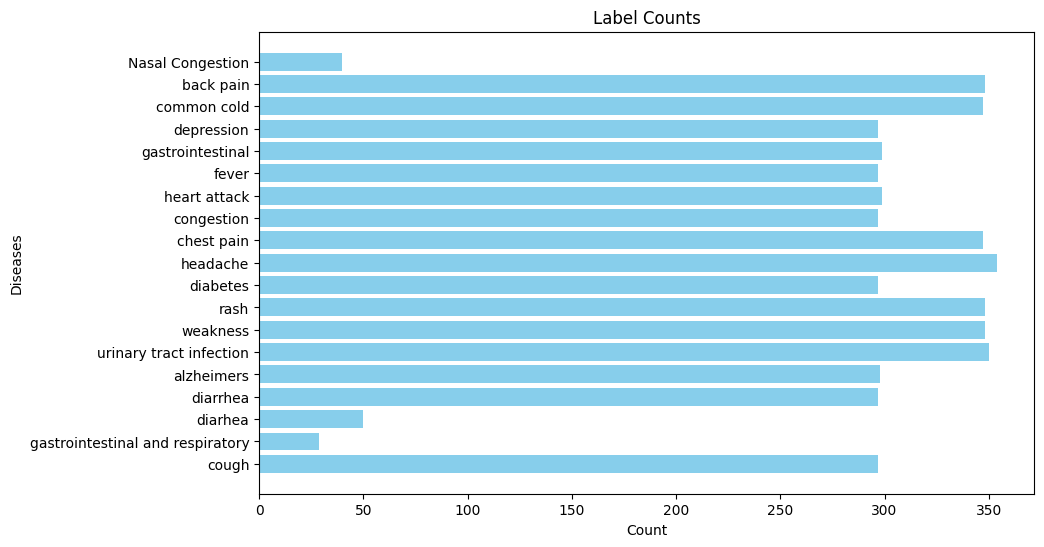

In [ ]:
# Assuming med_data['labels'] is your list of labels
labels = med_data['labels']

# Calculate the counts of each label
label_counts = {label: labels.count(label) for label in set(labels)}

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(label_counts.keys()), list(label_counts.values()), color='skyblue')
plt.ylabel('Diseases')
plt.xlabel('Count')
plt.title('Label Counts')
plt.show()

#Intent Classification:

In [ ]:
def preprocess(inp):
  preprocessed_texts = []
  stop_words = set(stopwords.words('english'))
  for text in inp:

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #remove stop words
    #words = text.split()
    #filtered_words = [word for word in words if word.lower() not in stop_words]
    #preprocessed_texts.append(' '.join(filtered_words))
    preprocessed_texts.append(text)
  return preprocessed_texts

In [ ]:
preprocessed_texts = preprocess(med_data['inputs'])

In [ ]:
le = LabelEncoder()
new_labels = le.fit_transform(med_data['labels'])
class_names = le.classes_
new_labels[:10]

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [ ]:
label_mapping = {class_name: index for index, class_name in enumerate(class_names)}
print(label_mapping)

{'Nasal Congestion': 0, 'alzheimers': 1, 'back pain': 2, 'chest pain': 3, 'common cold': 4, 'congestion': 5, 'cough': 6, 'depression': 7, 'diabetes': 8, 'diarhea': 9, 'diarrhea': 10, 'fever': 11, 'gastrointestinal': 12, 'gastrointestinal and respiratory': 13, 'headache': 14, 'heart attack': 15, 'rash': 16, 'urinary tract infection': 17, 'weakness': 18}


In [ ]:
preprocessed_texts[:10]

['im experiencing loose stools',
 'i have frequent bowel movements',
 'i have watery bowel movements',
 'i have an upset stomach',
 'im experiencing abdominal discomfort',
 'i have the runs',
 'im suffering from bowel issues',
 'i have loose bowel movements',
 'im experiencing bowel urgency',
 'i have an upset stomach and loose stools']

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize a BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Find the maximum length of the sequences
def ic_preprocess(preprocessed_txts, lbls):
  # Tokenize and encode the text data
  input_ids = []
  attention_masks = []
  max_length = 0
  for text in preprocessed_txts:
    encoded_dict = tokenizer(text, add_special_tokens=True, return_tensors='pt')
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    max_length = max(max_length, input_id.shape[1])

# Pad the sequences
  for i in range(len(input_ids)):
    input_ids[i] = torch.cat([input_ids[i], torch.zeros(1, max_length - input_ids[i].shape[1]).long()], dim=1)
    attention_masks[i] = torch.cat([attention_masks[i], torch.zeros(1, max_length - attention_masks[i].shape[1]).long()], dim=1)

  input_ids = torch.cat(input_ids, dim=0).to(device)
  attention_masks = torch.cat(attention_masks, dim=0).to(device)
  if lbls is not None:
    labels = torch.tensor(lbls).to(device)
    return input_ids, attention_masks, labels

  else:
    return input_ids, attention_masks

input_ids, attention_masks, labels = ic_preprocess(preprocessed_texts, new_labels)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Combine input_ids, attention_masks, and labels into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Split dataset into train and test sets (adjust the split ratio as needed)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 16  # Adjust as needed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # Multiplying by 2 because we have bidirectional LSTM

    def attention(self, lstm_output, final_state):
        hidden = final_state.view(-1, self.hidden_size*2, 1)  # Reshape final_state for attention calculation
        attention_weights = torch.bmm(lstm_output, hidden).squeeze(2)
        soft_attention_weights = F.softmax(attention_weights, dim=1).unsqueeze(2)
        attention_output = torch.bmm(lstm_output.permute(0,2,1), soft_attention_weights).squeeze(2)
        return attention_output.to(device)

    def forward(self, x):
        #x = x.to(device)
        x = x.to(device).long()
        embedded = self.embedding(x)
        embedded = embedded.to(device)
        lstm_out, (hn, cn) = self.lstm(embedded)
        attention_out = self.attention(lstm_out, hn[-2:])
        output = self.fc(attention_out)
        return output.to(device)

In [ ]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = x.to(device)
        embedded = self.embedding(x)
        embedded = embedded.to(device)
        rnn_out, _ = self.rnn(embedded)
        # Take the last hidden state for both directions
        last_hidden_states = torch.cat((rnn_out[:, -1, :hidden_size], rnn_out[:, 0, hidden_size:]), dim=1)
        output = self.fc(last_hidden_states)
        return output.to(device)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, num_layers, num_classes, nhead, d_model):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = x.to(device)
        embedded = self.embedding(x)
        embedded = self.pos_encoder(embedded)
        transformer_output = self.transformer_encoder(embedded)

        # Optionally, pool the output across the sequence dimension
        # For instance, by averaging or taking the output corresponding to the [CLS] token, if used
        pooled_output = transformer_output.mean(dim=1)

        output = self.fc(pooled_output)
        return output.to(device)

In [ ]:
# Define hyperparameters
input_size = len(tokenizer.vocab)  # Size of vocabulary
hidden_size = 128
num_layers = 2
num_classes = len(set(med_data['labels']))

# Initialize the model
model = LSTMWithAttention(input_size, hidden_size, num_layers, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 4571155
all model parameters: 4571155
percentage of trainable model parameters: 100.00%


In [ ]:
hidden_size = 64
num_layers = 1

model2 = BiRNN(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
nhead = 4  # Number of heads in the multiheadattention models
hidden_size = 128
num_layers = 2
d_model = hidden_size  # The dimension of the feedforward network model in nn.Transformer

# Initialize the Transformer model
model3 = TransformerClassifier(input_size, num_layers, num_classes, nhead, d_model).to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
model_weights_dir = '/content/gdrive/MyDrive/healthbot/LSTMwA/weights/'
model_dir = '/content/gdrive/MyDrive/healthbot/LSTMwA/'
os.makedirs(model_weights_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

best_test_accuracy = 0.0

# Lists to store training and testing accuracy, as well as loss
train_accuracy_list = []
test_accuracy_list = []
loss_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_correct_train = 0
    total_train = 0
    total_loss_train = 0

    for batch in train_dataloader:
        inputs, masks, labels = batch
        inputs, masks, labels  = inputs.to(device), masks.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()
        total_loss_train += loss.item()

    # Calculate training accuracy and loss
    train_accuracy = 100 * total_correct_train / total_train
    average_train_loss = total_loss_train / len(train_dataloader)

    # Validation/testing loop
    model.eval()  # Set the model to evaluation mode
    total_correct_test = 0
    total_test = 0
    total_loss_test = 0

    with torch.no_grad():
        for batch in test_dataloader:
            inputs, masks, labels = batch
            inputs, masks, labels  = inputs.to(device), masks.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)

            total_test += labels.size(0)
            total_correct_test += (predicted == labels).sum().item()
            total_loss_test += loss.item()

    # Calculate testing accuracy and loss
    test_accuracy = 100 * total_correct_test / total_test
    average_test_loss = total_loss_test / len(test_dataloader)

    # Save model weights if current test accuracy is better than previous best
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        model_name = f'lstm_w_attn_epoch_{epoch+1}_acc_{test_accuracy:.2f}.pt'
        model_path = os.path.join(model_weights_dir, model_name)
        torch.save(model.state_dict(), model_path)

    # Append accuracy and loss to lists
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    loss_list.append(average_train_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Accuracy: {train_accuracy:.2f}%, Testing Accuracy: {test_accuracy:.2f}%, Average Loss: {average_train_loss:.4f}')


# Save entire model after training completion


model_full_name = 'lstm_w_attn_full_final.pt'
model_full_path = os.path.join(model_dir, model_full_name)
torch.save(model, model_full_path)

Epoch 1/10, Training Accuracy: 33.84%, Testing Accuracy: 90.21%, Average Loss: 2.0592
Epoch 2/10, Training Accuracy: 94.21%, Testing Accuracy: 94.63%, Average Loss: 0.1895
Epoch 3/10, Training Accuracy: 96.38%, Testing Accuracy: 94.37%, Average Loss: 0.0966
Epoch 4/10, Training Accuracy: 97.10%, Testing Accuracy: 94.45%, Average Loss: 0.0678
Epoch 5/10, Training Accuracy: 97.57%, Testing Accuracy: 95.67%, Average Loss: 0.0516
Epoch 6/10, Training Accuracy: 97.53%, Testing Accuracy: 94.97%, Average Loss: 0.0472
Epoch 7/10, Training Accuracy: 97.77%, Testing Accuracy: 95.15%, Average Loss: 0.0400
Epoch 8/10, Training Accuracy: 97.77%, Testing Accuracy: 95.23%, Average Loss: 0.0376
Epoch 9/10, Training Accuracy: 97.68%, Testing Accuracy: 94.97%, Average Loss: 0.0336
Epoch 10/10, Training Accuracy: 97.83%, Testing Accuracy: 95.93%, Average Loss: 0.0362


In [ ]:
tokenizer_save_path = '/content/gdrive/MyDrive/healthbot/LSTMwA/'
tokenizer.save_pretrained(tokenizer_save_path)

('/content/gdrive/MyDrive/healthbot/LSTMwA/tokenizer_config.json',
 '/content/gdrive/MyDrive/healthbot/LSTMwA/special_tokens_map.json',
 '/content/gdrive/MyDrive/healthbot/LSTMwA/vocab.txt',
 '/content/gdrive/MyDrive/healthbot/LSTMwA/added_tokens.json')

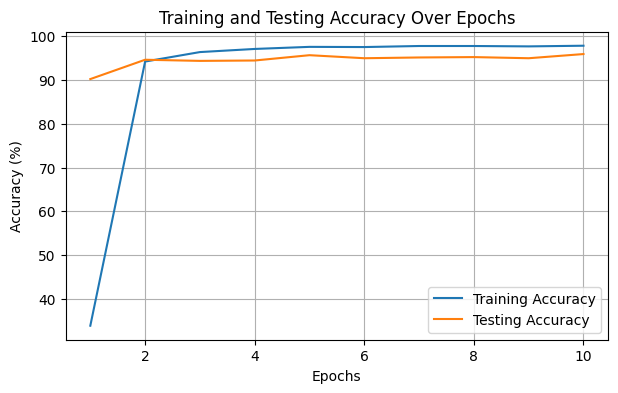

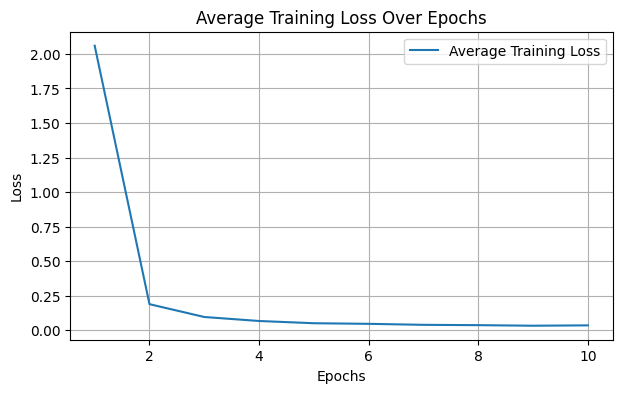

In [ ]:
# Plotting the training progress
plt.figure(figsize=(7, 4))
plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracy_list, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Testing Accuracy Over Epochs')
plt.grid(True)

plt.figure(figsize=(7, 4))
plt.plot(range(1, num_epochs+1), loss_list, label='Average Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Average Training Loss Over Epochs')
plt.grid(True)

plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Lists to store all predictions and true labels
all_preds = []
all_true_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch in test_dataloader:
        inputs, masks, labels = batch
        inputs, masks, labels  = inputs.to(device), masks.to(device), labels.to(device)
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_true_labels, all_preds, target_names=class_names))


Classification Report:
                         precision    recall  f1-score   support

             alzheimers       1.00      1.00      1.00        55
              back pain       0.98      0.98      0.98        59
             chest pain       0.95      1.00      0.97        73
            common cold       0.97      0.72      0.83       100
             congestion       0.90      1.00      0.95        62
                  cough       0.97      0.95      0.96        63
             depression       1.00      0.98      0.99        62
               diabetes       0.82      0.97      0.89       115
               diarrhea       1.00      0.99      0.99        86
                  fever       0.97      1.00      0.98        61
       gastrointestinal       0.97      0.95      0.96        61
               headache       1.00      1.00      1.00        77
           heart attack       1.00      0.94      0.97        80
                   rash       1.00      0.99      0.99        70
u

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(all_true_labels, all_preds)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

for idx, class_accuracy in enumerate(class_accuracies):
    print(f"Accuracy of {class_names[idx]}: {class_accuracy * 100:.2f}%")


Accuracy of alzheimers: 100.00%
Accuracy of back pain: 98.31%
Accuracy of chest pain: 100.00%
Accuracy of common cold: 72.00%
Accuracy of congestion: 100.00%
Accuracy of cough: 95.24%
Accuracy of depression: 98.39%
Accuracy of diabetes: 97.39%
Accuracy of diarrhea: 98.84%
Accuracy of fever: 100.00%
Accuracy of gastrointestinal: 95.08%
Accuracy of headache: 100.00%
Accuracy of heart attack: 93.75%
Accuracy of rash: 98.57%
Accuracy of urinary tract infection: 100.00%
Accuracy of weakness: 98.53%


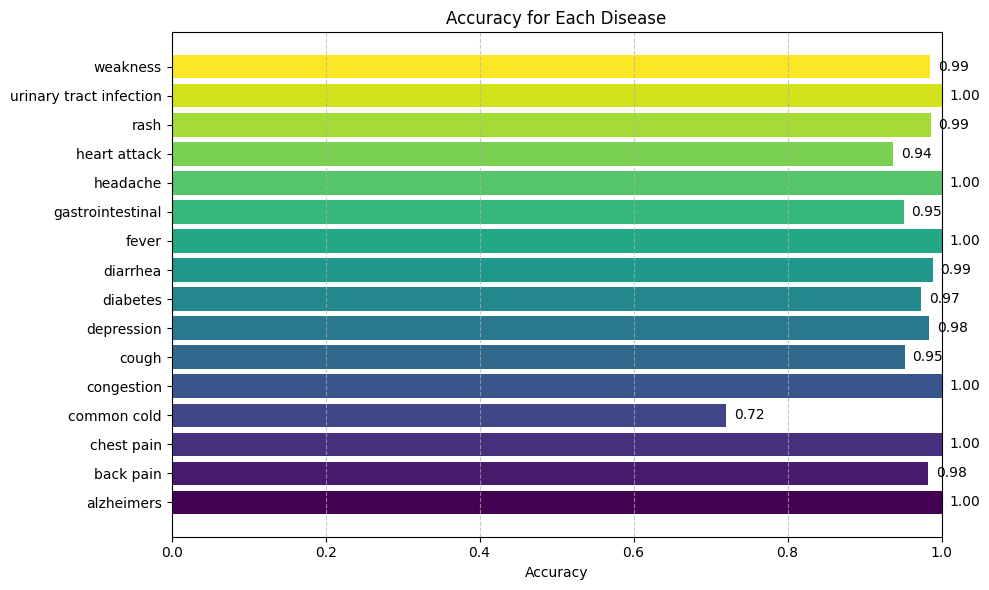

In [ ]:
# Calculate confusion matrix and class accuracies
cm = confusion_matrix(all_true_labels, all_preds)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Create a horizontal bar plot with different colors
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(class_names)))
plt.barh(class_names, class_accuracies, color=colors)
plt.xlabel('Accuracy')
plt.title('Accuracy for Each Disease')

# Display the accuracies inside the plot
for i, v in enumerate(class_accuracies):
    plt.text(v + 0.01, i, f'{v:.2f}', color='black', va='center')

plt.xlim(0, 1)  # Set the x-axis limit between 0 and 1 (assuming accuracy is in the range [0, 1])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
num_epochs = 25
model_weights_dir2 = '/content/gdrive/MyDrive/healthbot/Bi-RNN/weights/'
model_dir2 = '/content/gdrive/MyDrive/healthbot/Bi-RNN/'
os.makedirs(model_weights_dir2, exist_ok=True)
os.makedirs(model_dir2, exist_ok=True)

best_test_accuracy = 0.0

# Lists to store training and testing accuracy, as well as loss
train_accuracy_list = []
test_accuracy_list = []
loss_list = []

# Training loop
for epoch in range(num_epochs):
    model2.train()  # Set the model to training mode
    total_correct_train = 0
    total_train = 0
    total_loss_train = 0

    for batch in train_dataloader:
        inputs, masks, labels = batch
        inputs, masks, labels  = inputs.to(device), masks.to(device), labels.to(device)
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()
        total_loss_train += loss.item()

    # Calculate training accuracy and loss
    train_accuracy = 100 * total_correct_train / total_train
    average_train_loss = total_loss_train / len(train_dataloader)

    # Validation/testing loop
    model2.eval()  # Set the model to evaluation mode
    total_correct_test = 0
    total_test = 0
    total_loss_test = 0

    with torch.no_grad():
        for batch in test_dataloader:
            inputs, masks, labels = batch
            inputs, masks, labels  = inputs.to(device), masks.to(device), labels.to(device)
            outputs = model2(inputs)

            _, predicted = torch.max(outputs.data, 1)

            total_test += labels.size(0)
            total_correct_test += (predicted == labels).sum().item()
            total_loss_test += loss.item()

    # Calculate testing accuracy and loss
    test_accuracy = 100 * total_correct_test / total_test
    average_test_loss = total_loss_test / len(test_dataloader)

    # Save model weights if current test accuracy is better than previous best
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        model_name = f'bi_rnn_epoch_{epoch+1}_acc_{test_accuracy:.2f}.pt'
        model_path = os.path.join(model_weights_dir2, model_name)
        torch.save(model2.state_dict(), model_path)

    # Append accuracy and loss to lists
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    loss_list.append(average_train_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Accuracy: {train_accuracy:.2f}%, Testing Accuracy: {test_accuracy:.2f}%, Average Loss: {average_train_loss:.4f}')



model_full_name2 = 'bi_rnn_full_final.pt'
model_full_path2 = os.path.join(model_dir2, model_full_name2)
torch.save(model2, model_full_path2)

Epoch 1/25, Training Accuracy: 11.14%, Testing Accuracy: 10.57%, Average Loss: 2.6968
Epoch 2/25, Training Accuracy: 16.65%, Testing Accuracy: 16.29%, Average Loss: 2.3575
Epoch 3/25, Training Accuracy: 23.67%, Testing Accuracy: 26.69%, Average Loss: 2.0419
Epoch 4/25, Training Accuracy: 36.79%, Testing Accuracy: 43.41%, Average Loss: 1.5895
Epoch 5/25, Training Accuracy: 54.35%, Testing Accuracy: 60.49%, Average Loss: 1.2005
Epoch 6/25, Training Accuracy: 63.91%, Testing Accuracy: 63.52%, Average Loss: 0.9982
Epoch 7/25, Training Accuracy: 73.36%, Testing Accuracy: 74.09%, Average Loss: 0.7959
Epoch 8/25, Training Accuracy: 60.18%, Testing Accuracy: 45.06%, Average Loss: 1.1568
Epoch 9/25, Training Accuracy: 55.60%, Testing Accuracy: 54.68%, Average Loss: 1.0811
Epoch 10/25, Training Accuracy: 69.72%, Testing Accuracy: 73.74%, Average Loss: 0.8339
Epoch 11/25, Training Accuracy: 83.94%, Testing Accuracy: 82.06%, Average Loss: 0.5339
Epoch 12/25, Training Accuracy: 90.24%, Testing Accu

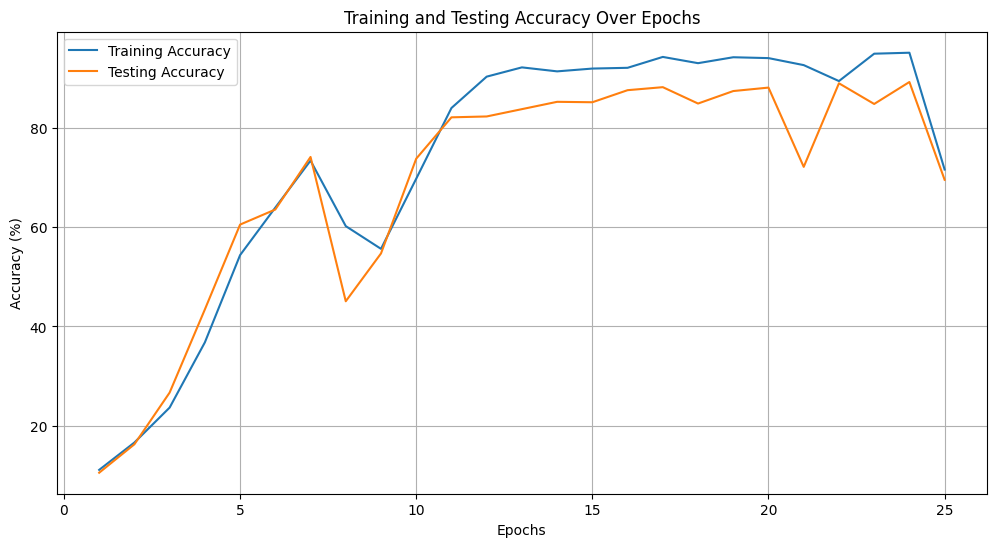

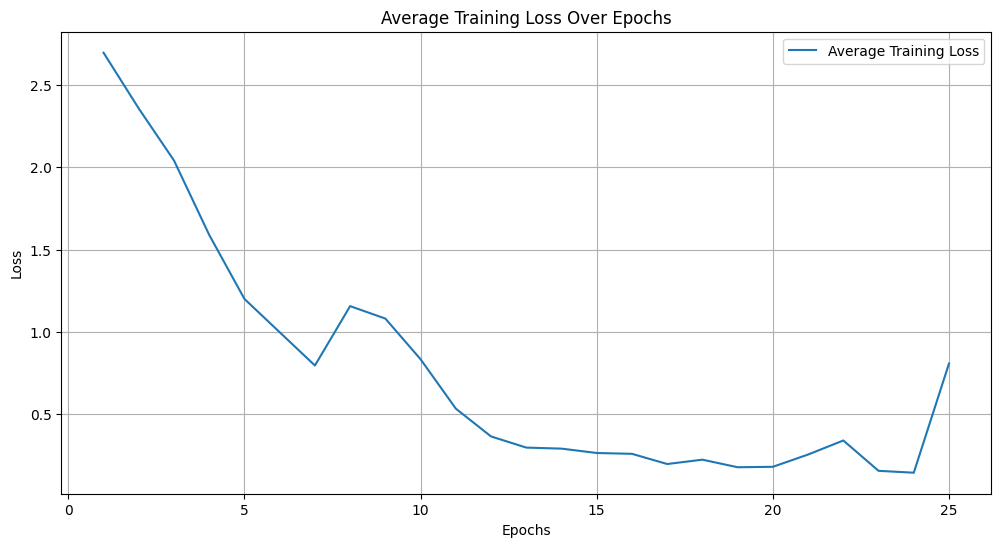

In [ ]:
# Plotting the training progress
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracy_list, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Testing Accuracy Over Epochs')
plt.grid(True)

plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs+1), loss_list, label='Average Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Average Training Loss Over Epochs')
plt.grid(True)

plt.show()

In [ ]:
num_epochs = 15
model_weights_dir3 = '/content/gdrive/MyDrive/healthbot/Transformer/weights/'
model_dir3 = '/content/gdrive/MyDrive/healthbot/Transformer/'
os.makedirs(model_weights_dir3, exist_ok=True)
os.makedirs(model_dir3, exist_ok=True)

best_test_accuracy = 0.0

# Lists to store training and testing accuracy, as well as loss
train_accuracy_list = []
test_accuracy_list = []
loss_list = []

# Training loop
for epoch in range(num_epochs):
    model3.train()  # Set the model to training mode
    total_correct_train = 0
    total_train = 0
    total_loss_train = 0

    for batch in train_dataloader:
        inputs, masks, labels = batch
        inputs, masks, labels  = inputs.to(device), masks.to(device), labels.to(device)
        outputs = model3(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()
        total_loss_train += loss.item()

    # Calculate training accuracy and loss
    train_accuracy = 100 * total_correct_train / total_train
    average_train_loss = total_loss_train / len(train_dataloader)

    # Validation/testing loop
    model3.eval()  # Set the model to evaluation mode
    total_correct_test = 0
    total_test = 0
    total_loss_test = 0

    with torch.no_grad():
        for batch in test_dataloader:
            inputs, masks, labels = batch
            inputs, masks, labels  = inputs.to(device), masks.to(device), labels.to(device)
            outputs = model3(inputs)

            _, predicted = torch.max(outputs.data, 1)

            total_test += labels.size(0)
            total_correct_test += (predicted == labels).sum().item()
            total_loss_test += loss.item()

    # Calculate testing accuracy and loss
    test_accuracy = 100 * total_correct_test / total_test
    average_test_loss = total_loss_test / len(test_dataloader)

    # Save model weights if current test accuracy is better than previous best
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        model_name = f'transformer_epoch_{epoch+1}_acc_{test_accuracy:.2f}.pt'
        model_path = os.path.join(model_weights_dir3, model_name)
        torch.save(model3.state_dict(), model_path)

    # Append accuracy and loss to lists
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    loss_list.append(average_train_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Accuracy: {train_accuracy:.2f}%, Testing Accuracy: {test_accuracy:.2f}%, Average Loss: {average_train_loss:.4f}')



model_full_name3 = 'transformer_full_final.pt'
model_full_path3 = os.path.join(model_dir3, model_full_name3)
torch.save(model3, model_full_path3)

Epoch 1/15, Training Accuracy: 42.29%, Testing Accuracy: 84.14%, Average Loss: 1.7826
Epoch 2/15, Training Accuracy: 89.27%, Testing Accuracy: 91.85%, Average Loss: 0.3865
Epoch 3/15, Training Accuracy: 92.41%, Testing Accuracy: 94.28%, Average Loss: 0.2428
Epoch 4/15, Training Accuracy: 94.04%, Testing Accuracy: 94.37%, Average Loss: 0.1890
Epoch 5/15, Training Accuracy: 94.32%, Testing Accuracy: 94.11%, Average Loss: 0.1640
Epoch 6/15, Training Accuracy: 95.06%, Testing Accuracy: 93.41%, Average Loss: 0.1546
Epoch 7/15, Training Accuracy: 94.99%, Testing Accuracy: 94.89%, Average Loss: 0.1491
Epoch 8/15, Training Accuracy: 95.47%, Testing Accuracy: 95.23%, Average Loss: 0.1297
Epoch 9/15, Training Accuracy: 94.86%, Testing Accuracy: 95.15%, Average Loss: 0.1430
Epoch 10/15, Training Accuracy: 96.18%, Testing Accuracy: 94.97%, Average Loss: 0.1174
Epoch 11/15, Training Accuracy: 95.21%, Testing Accuracy: 95.15%, Average Loss: 0.1381
Epoch 12/15, Training Accuracy: 95.47%, Testing Accu

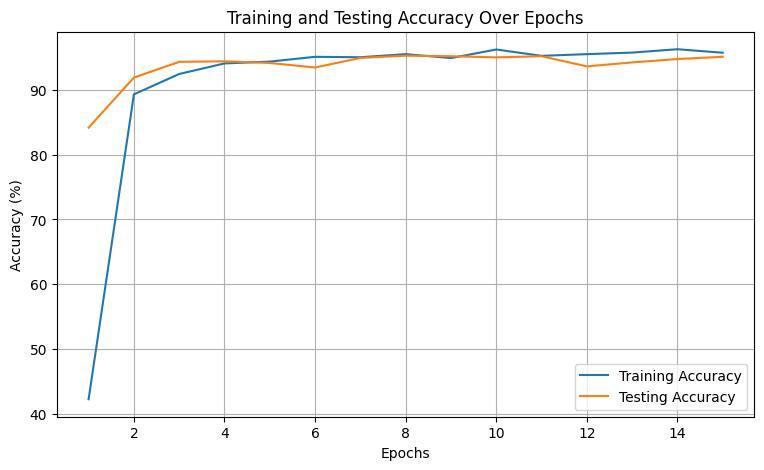

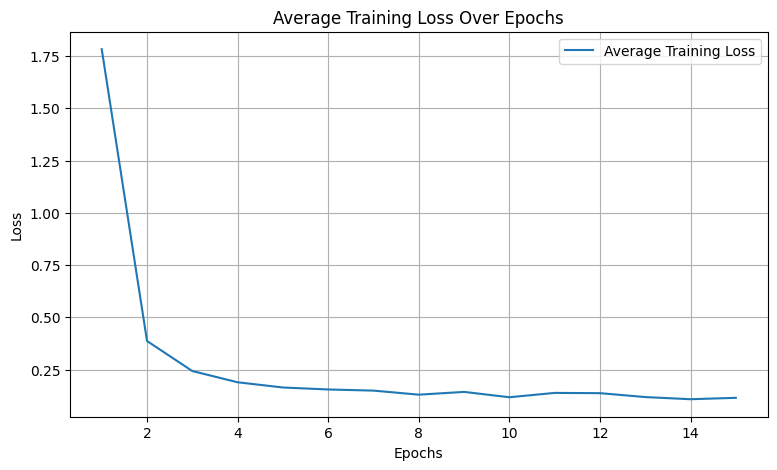

In [ ]:
# Plotting the training progress
plt.figure(figsize=(9, 5))
plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracy_list, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Testing Accuracy Over Epochs')
plt.grid(True)

plt.figure(figsize=(9, 5))
plt.plot(range(1, num_epochs+1), loss_list, label='Average Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Average Training Loss Over Epochs')
plt.grid(True)

plt.show()

#Named Entity Recognition:

In [ ]:
preprocessed_texts1 = []

stop_words = set(stopwords.words('english'))
for text in med_data['inputs']:
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #remove stop words
    #words = text.split()
    #filtered_words = [word for word in words if word.lower() not in stop_words]
    #preprocessed_texts1.append(' '.join(filtered_words))
    #preprocessed_texts1.append(text)

In [ ]:
all_words=[]
for texts in preprocessed_texts1:
    words = texts.split()
    for word in words:
        if len(word)<25:
            all_words.append(word)

all_unique_words = list(set(all_words))

In [ ]:
from collections import defaultdict

ner_queries = defaultdict(list)

for i,input in enumerate(med_data['inputs']):
  if med_data['labels'][i] not in ner_queries:
    ner_queries[med_data['labels'][i]] = word_tokenize(input)
  else:
    ner_queries[med_data['labels'][i]].append(word_tokenize(input))


In [ ]:
#creating a .pkl for the updated data
path = "/content/gdrive/MyDrive/healthbot/"
file_name = 'ner_queries.json'
with open(path + file_name , 'w') as file:
    json.dump(ner_queries, file)

In [ ]:
import random
random_ind = [random.randint(501, 2566) for _ in range(500)]
for index in random_ind:
    if index < len(med_data['inputs']):
        print(word_tokenize(med_data['inputs'][index]))

In [ ]:
med_data['inputs'].pop(991)
med_data['labels'].pop(991)

med_data['inputs'].pop(469)
med_data['labels'].pop(469)

'diabetes'

In [ ]:
len(med_data['inputs'])

2565

In [ ]:
with open('/content/gdrive/MyDrive/healthbot/ner_queries_label.pkl', 'rb') as file:
    ner_query_label = pickle.load(file)

In [ ]:
with open('/content/gdrive/MyDrive/healthbot/ner_queries_label.pkl', 'wb') as file:
    pickle.dump(ner_query_label, file)

In [ ]:
import re
pattern = r"\[.*?\] = \[.*?\]"
matches = re.findall(pattern, ner_query_label)

# Initialize lists to store text lists and number arrays
text_lists = []
number_arrays = []

# Iterate through the matches and extract text lists and number arrays
for match in matches:
    parts = match.split(' = ')
    text_list = eval(parts[0])
    number_array = eval(parts[1])
    text_lists.append(text_list)
    number_arrays.append(number_array)

In [ ]:
input_texts = []
for i in text_lists:
  input_texts.append(" ".join(i))

In [ ]:
""" {'MISC': 0, 'medicine': 1, 'symptom': 2, 'disease': 3, 'severity': 4, 'sensation': 5, 'body': 6} """

{'MISC': 0, 'medicine': 1, 'symptom': 2, 'disease': 3, 'severity': 4, 'sensation': 5, 'body': 6}


In [ ]:
texts = input_texts
labels = number_arrays

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts = [tokenizer.tokenize(text) for text in texts]
input_ids = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")['input_ids']

# Calculate the maximum sequence length in the input
max_seq_length = input_ids.shape[1]

# Convert labels to tensors with padding
label_ids = []
for label in labels:
    padded_label = label + [0] * (max_seq_length - len(label))
    label_ids.append(padded_label)

label_ids = torch.tensor(label_ids)

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [ ]:
# Split the data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, label_ids, test_size=0.2, random_state=42)

# Create DataLoader for training and validation data
train_data = TensorDataset(train_inputs, train_labels)
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)

val_data = TensorDataset(val_inputs, val_labels)
val_dataloader = DataLoader(val_data, batch_size=4)

In [ ]:
num_epochs = 5
label2id = {'MISC': 0, 'medicine': 1, 'symptom': 2, 'disease': 3, 'severity': 4, 'sensation': 5, 'body': 6}

# Initialize BERT for token classification
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(label2id))

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * num_epochs)

# Define loss function
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 108897031
all model parameters: 108897031
percentage of trainable model parameters: 100.00%


In [ ]:
print(torch.__version__)

2.1.0+cu118


In [ ]:
print(torch.cuda.memory_allocated())

649611776


Epoch 1/5 - Average Training Loss: 0.30551860729853314 - Training Accuracy: 0.9237
Epoch 1/5 - Average Validation Loss: 0.14761135162729205 - Validation Accuracy: 0.9536
Epoch 2/5 - Average Training Loss: 0.16241841384953307 - Training Accuracy: 0.9495
Epoch 2/5 - Average Validation Loss: 0.12623823479269491 - Validation Accuracy: 0.9574
Epoch 3/5 - Average Training Loss: 0.1330690903141517 - Training Accuracy: 0.9571
Epoch 3/5 - Average Validation Loss: 0.1244142996429494 - Validation Accuracy: 0.9576
Epoch 4/5 - Average Training Loss: 0.11828698535529218 - Training Accuracy: 0.9604
Epoch 4/5 - Average Validation Loss: 0.11676717606006247 - Validation Accuracy: 0.9606
Epoch 5/5 - Average Training Loss: 0.1076768642479135 - Training Accuracy: 0.9645
Epoch 5/5 - Average Validation Loss: 0.11686552028087052 - Validation Accuracy: 0.9612


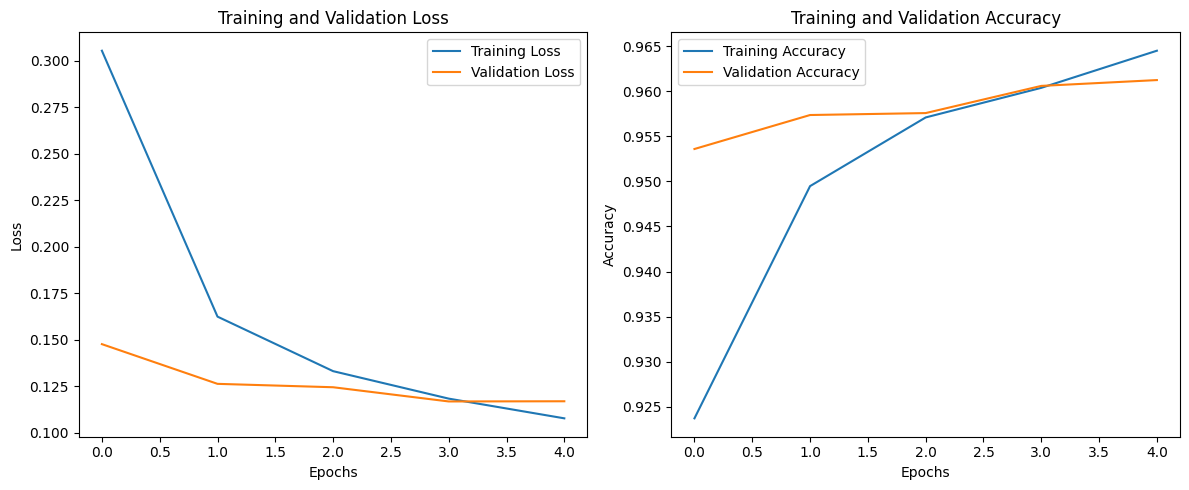

Trained model saved to: /content/gdrive/MyDrive/healthbot/bert_ner


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Training loop
train_losses = []
val_losses = []
train_accuracies = []  # List to store training accuracies
val_accuracies = []    # List to store validation accuracies

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    train_predictions = []  # List to store training predictions
    train_targets = []      # List to store training targets

    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Create an attention mask to ignore padded tokens
        attention_mask = (inputs != tokenizer.pad_token_id).long()
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)

        # Compute the loss
        loss = outputs.loss

        # Get predicted labels
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=2)
        train_predictions.extend(predictions.view(-1).cpu().numpy())
        train_targets.extend(labels.view(-1).cpu().numpy())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Calculate training accuracy
    train_accuracy = accuracy_score(train_targets, train_predictions)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Average Training Loss: {avg_train_loss} - Training Accuracy: {train_accuracy:.4f}")

    # Validation loop
    model.eval()
    total_val_loss = 0
    val_predictions = []  # List to store validation predictions
    val_targets = []      # List to store validation targets

    for batch in val_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Create an attention mask to ignore padded tokens
        attention_mask = (inputs != tokenizer.pad_token_id).long()

        with torch.no_grad():
            outputs = model(inputs, attention_mask=attention_mask, labels=labels)

            # Compute the loss
            loss = outputs.loss
            total_val_loss += loss.item()

            # Get predicted labels
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=2)
            val_predictions.extend(predictions.view(-1).cpu().numpy())
            val_targets.extend(labels.view(-1).cpu().numpy())

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Calculate validation accuracy
    val_accuracy = accuracy_score(val_targets, val_predictions)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Average Validation Loss: {avg_val_loss} - Validation Accuracy: {val_accuracy:.4f}")

# Plot the loss and accuracy curves

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()



# Save the trained model to your desired path
model_path = "/content/gdrive/MyDrive/healthbot/bert_ner"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"Trained model saved to: {model_path}")

In [ ]:
# Calculate recall, precision, and F1 score for validation data
val_recall = recall_score(val_targets, val_predictions, average='macro')
val_precision = precision_score(val_targets, val_predictions, average='macro')
val_f1 = f1_score(val_targets, val_predictions, average='macro')

print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

Validation Recall: 0.5581
Validation Precision: 0.6124
Validation F1 Score: 0.5807


In [ ]:
test_texts  = texts[:5]

test_input_ids = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")['input_ids']

model.eval()

# Disable gradient computation for inference
with torch.no_grad():
    # Forward pass to get predictions
    outputs = model(test_input_ids)
    predictions = torch.argmax(outputs.logits, dim=2)  # Get the predicted label IDs

# Convert label IDs back to labels using the tokenizer's decode function
#predicted_labels = [tokenizer.decode(ids, skip_special_tokens=True) for ids in predictions[0].tolist()]


In [ ]:
predictions

tensor([[0, 0, 5, 2, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 6, 6, 2, 0, 0, 0, 0],
        [0, 0, 0, 6, 2, 2, 0, 0, 0, 0],
        [0, 0, 0, 6, 6, 0, 0, 0, 0, 0],
        [0, 0, 5, 6, 4, 0, 0, 0, 0, 0]])

In [ ]:
# Print the predicted labels for each test sentence
for text, labels in zip(test_texts, predictions):
    print(f"Text: {text}")
    print(f"Predicted Labels: {labels}")
    print()

Text: i 'm experiencing loose stools .
Predicted Labels: tensor([0, 0, 5, 2, 2, 0, 0, 0, 0, 0])

Text: i have frequent bowel movements .
Predicted Labels: tensor([0, 0, 0, 6, 6, 2, 0, 0, 0, 0])

Text: i have watery bowel movements .
Predicted Labels: tensor([0, 0, 0, 6, 2, 2, 0, 0, 0, 0])

Text: i have an upset stomach .
Predicted Labels: tensor([0, 0, 0, 6, 6, 0, 0, 0, 0, 0])

Text: i 'm experiencing abdominal discomfort .
Predicted Labels: tensor([0, 0, 5, 6, 4, 0, 0, 0, 0, 0])



# Contextual Understanding:

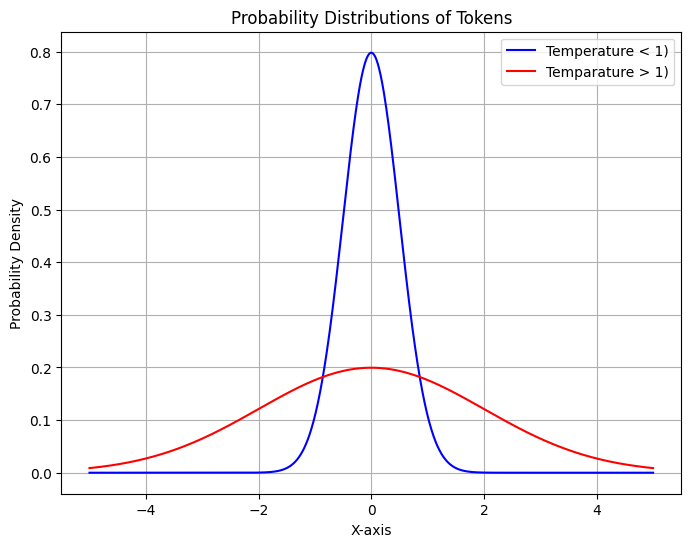

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define parameters for the Gaussian distributions
mu1 = 0      # Mean for the first Gaussian
sigma1 = 1   # Standard deviation for the first Gaussian
temperature1 = 2  # Temperature parameter for the first Gaussian

mu2 = 0      # Mean for the second Gaussian
sigma2 = 1   # Standard deviation for the second Gaussian
temperature2 = 0.5  # Temperature parameter for the second Gaussian

# Generate data points for the x-axis
x = np.linspace(-5, 5, 1000)

# Calculate the probability density functions (PDFs) for the two Gaussians
pdf1 = norm.pdf(x, mu1, sigma1 / temperature1)
pdf2 = norm.pdf(x, mu2, sigma2 / temperature2)

# Plot the two Gaussian distributions
plt.figure(figsize=(8, 6))
plt.plot(x, pdf1, label='Temperature < 1)', color='blue')
plt.plot(x, pdf2, label='Temparature > 1)', color='red')

# Add labels and a legend
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.title('Probability Distributions of Tokens')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
#loading the knowledge graph
path = "/content/gdrive/MyDrive/healthbot/"
file_name = 'knowledge_graph.pkl'
with open(path + file_name , 'rb') as file:
    knowledge_graph = pickle.load(file)

In [ ]:
path = "/content/gdrive/MyDrive/healthbot/"
file_name = 'input_queries_cu.pkl'
with open(path + file_name , 'rb') as file:
    input_queries_cu = pickle.load(file)

file_name1 = "input_queries_responses_cu.pkl"
with open(path + file_name1 , 'rb') as file:
    input_queries_responses_cu = pickle.load(file)

In [ ]:
inp_queries = []
inp_responses = []
for disease, queries in input_queries_cu.items():
  inp_queries.extend(queries)

for disease1, responses in input_queries_responses_cu.items():
  inp_responses.extend(responses)

In [ ]:
path = "/content/gdrive/MyDrive/healthbot/"
file_name = 'ques_resp.pkl'
with open(path + file_name , 'rb') as file:
    ques_resp = pickle.load(file)

file_name1 = 'ques_resp2.pkl'
with open(path + file_name1 , 'rb') as file:
    ques_resp2 = pickle.load(file)

In [ ]:
inp_ques = []
inp_resp = []
inp_ques.extend(ques_resp['queries'])
inp_ques.extend(ques_resp2['queries'])
inp_resp.extend(ques_resp['responses'])
inp_resp.extend(ques_resp2['responses'])

In [ ]:
inp_queries.extend(ques_resp['queries'])
inp_queries.extend(ques_resp2['queries'])
inp_responses.extend(ques_resp['responses'])
inp_responses.extend(ques_resp2['responses'])

In [ ]:
len(inp_queries)
len(inp_responses)

4293

### With GPT-2


In [ ]:
torch.cuda.empty_cache()

In [ ]:
inp_prompts = []
for i in range(len(inp_queries)):
  start_prompt = "Answer the following question:\n\n"
  prompt = start_prompt + inp_queries[i]
  inp_prompts.append(prompt)

### prompts with lstm outputs:

In [ ]:
lstm_w_attn_path = '/content/gdrive/MyDrive/healthbot/LSTMwA/lstm_w_attn_full_final.pt'
tokenizer_path = '/content/gdrive/MyDrive/healthbot/LSTMwA/'
lstm_w_attn = torch.load(lstm_w_attn_path)
lstm_tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
lstm_w_attn = lstm_w_attn.to(device)
lstm_w_attn.eval()

LSTMWithAttention(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=16, bias=True)
)

In [ ]:
prepro_txts = preprocess(inp_queries)
ip_ids, attn_mask = ic_preprocess(prepro_txts, lbls=None)
ip_ids = ip_ids.to(device)
attn_mask = attn_mask.to(device)

['A', 's', 'h', 'w', 'i', 'n']

In [ ]:
def preprocess_for_lstm(text):
  text = [text]
  prepro_txts = preprocess(text)
  ip_ids, attn_mask = ic_preprocess(prepro_txts, lbls=None)
  ip_ids = ip_ids.to(device)
  attn_mask = attn_mask.to(device)

  with torch.no_grad():
    outputs = lstm_w_attn(ip_ids)#, attention_mask=attn_mask)
    _, predicts = torch.max(outputs.data, 1)

  inverted_label_dict = {v: k for k, v in label_mapping.items()}

  if isinstance(predicts, torch.Tensor):
    predicts = predicts.cpu().numpy()  # If predicts is a tensor
  predicts = [int(label) for label in predicts]  # Convert to int if they are numpy types or Python tensors

  # Map the predicted labels to string labels
  diseases = [inverted_label_dict[label] for label in predicts]
  return diseases[0]

In [ ]:
preprocess_for_lstm("What are the medicines of for Diabetes?")

'common cold'

In [ ]:
with torch.no_grad():
    outputs = lstm_w_attn(ip_ids)#, attention_mask=attn_mask)
    _, predicts = torch.max(outputs.data, 1)

inverted_label_dict = {v: k for k, v in label_mapping.items()}

if isinstance(predicts, torch.Tensor):
    predicts = predicts.cpu().numpy()  # If predicts is a tensor
predicts = [int(label) for label in predicts]  # Convert to int if they are numpy types or Python tensors

# Map the predicted labels to string labels
ic_diseases = [inverted_label_dict[label] for label in predicts]

In [ ]:
inp_prompts = []
for i in range(len(inp_queries)):
    disease = ic_diseases[i]
    start_prompt = f"For the context of {disease}, please consider the symptom and medicine information below:\n\n"

    # Include symptom and medicine information from the knowledge graph
    symptom_info = "\n".join([f"- {symptom}" for symptom in knowledge_graph[disease]['symptoms']])
    medicine_info = "\n".join([f"- {medicine}" for medicine in knowledge_graph[disease]['medicines']])

    prompt = start_prompt + f"Symptoms for {disease}:\n{symptom_info}\n\nMedicines for {disease}:\n{medicine_info}\n\n" + inp_queries[i]

    # Instruct the model to answer the question
    prompt += "\n\nPlease provide an answer to the following question:"

    inp_prompts.append(prompt)


In [ ]:
def generate_prompt(inp_text, disease, knowledge_graph):
    start_prompt = f"For the context of {disease}, please consider the symptom and medicine information below:\n\n"

    # Include symptom and medicine information from the knowledge graph
    symptom_info = "\n".join([f"- {symptom}" for symptom in knowledge_graph[disease]['symptoms']])
    medicine_info = "\n".join([f"- {medicine}" for medicine in knowledge_graph[disease]['medicines']])

    prompt = start_prompt + f"Symptoms for {disease}:\n{symptom_info}\n\nMedicines for {disease}:\n{medicine_info}\n\n" + inp_text

    # Instruct the model to answer the question
    prompt += "\n\nPlease provide an answer to the following question:"
    return prompt

In [ ]:
inp_prompts = []
for i in range(len(inp_queries)):
    disease = ic_diseases[i]
    start_prompt = f"For the context of {disease}, please answer the following question:\n\n"
    prompt = start_prompt + inp_queries[i]
    inp_prompts.append(prompt)

In [ ]:
# Example of dataset preparation
dataset = [{"prompt": query, "response": response}
           for query, response in zip(inp_prompts, inp_responses)]

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming dataset is a list of {'prompt': ..., 'response': ...}
train_val, test_data = train_test_split(dataset, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_val, test_size=(1/9), random_state=42)  # 1/9 of 90% = 10%

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Add special tokens if needed and resize token embeddings
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedding(50258, 768)

In [ ]:
def process_data(data, tokenizer):
    inputs = []
    attention_masks = []

    for item in data:
        encoded_dict = tokenizer.encode_plus(
            item['prompt'] + item['response'],
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        inputs.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return torch.cat(inputs, dim=0), torch.cat(attention_masks, dim=0)

# Assuming train_data, val_data, and test_data are lists of dicts with 'prompt' and 'response' keys
train_inputs, train_masks = process_data(train_data, tokenizer)
validation_inputs, validation_masks = process_data(val_data, tokenizer)
test_inputs, test_masks = process_data(test_data, tokenizer)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 8

train_dataset = TensorDataset(train_inputs, train_masks)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

validation_dataset = TensorDataset(validation_inputs, validation_masks)
validation_dataloader = DataLoader(validation_dataset, sampler=SequentialSampler(validation_dataset), batch_size=batch_size)

test_dataset = TensorDataset(test_inputs, test_masks)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

In [ ]:
!nvidia-smi

Sat Dec  2 07:01:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    50W / 400W |   1633MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 124440576
all model parameters: 124440576
percentage of trainable model parameters: 100.00%


In [ ]:
epochs = 10
train_losses = []
val_losses = []

for epoch_i in range(epochs):
    print(f'Epoch {epoch_i + 1}/{epochs}')
    total_train_loss = 0

    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_input_ids)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss}")

    total_eval_loss = 0
    model.eval()
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_input_ids)

        loss = outputs.loss
        total_eval_loss += loss.item()

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Average validation loss: {avg_val_loss}")

Epoch 1/10
Average training loss: 1.210443449921386
Average validation loss: 0.38253687266950254
Epoch 2/10
Average training loss: 0.322609814169795
Average validation loss: 0.16491971109752301
Epoch 3/10
Average training loss: 0.16566643614408583
Average validation loss: 0.08011568896472454
Epoch 4/10
Average training loss: 0.1006437540140956
Average validation loss: 0.06401756536905412
Epoch 5/10
Average training loss: 0.07998562248986821
Average validation loss: 0.0594668400094465
Epoch 6/10
Average training loss: 0.0701291959992675
Average validation loss: 0.056334578121701874
Epoch 7/10
Average training loss: 0.06392787086322557
Average validation loss: 0.05408755179356645
Epoch 8/10
Average training loss: 0.05967558961968089
Average validation loss: 0.0524317711867668
Epoch 9/10
Average training loss: 0.056131458070215794
Average validation loss: 0.05120352593561014
Epoch 10/10
Average training loss: 0.05357034883873407
Average validation loss: 0.050456573013906124


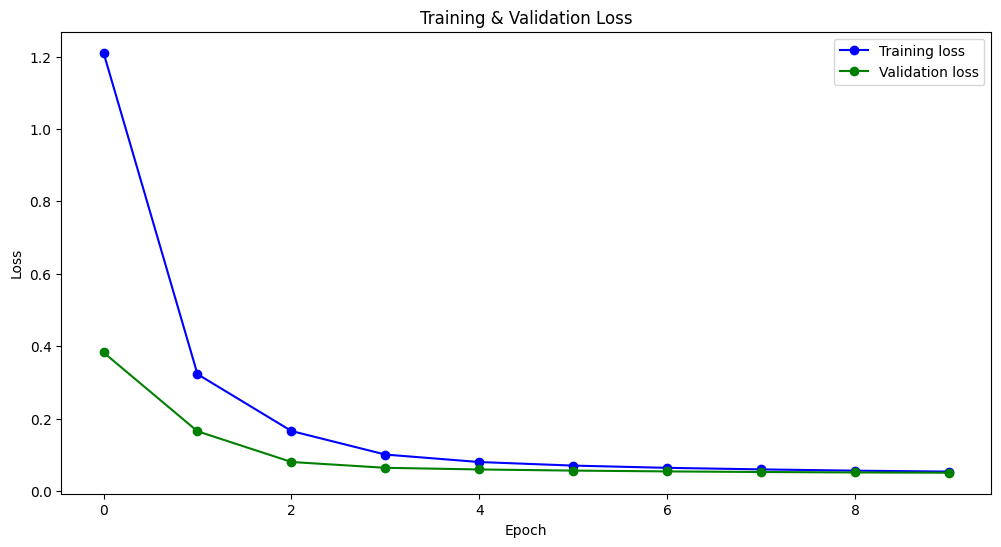

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, 'b-o', label="Training loss")
plt.plot(val_losses, 'g-o', label="Validation loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
epochs = 10
train_losses = []
val_losses = []

for epoch_i in range(epochs):
    print(f'Epoch {epoch_i + 1}/{epochs}')
    total_train_loss = 0

    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_input_ids)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss}")

    total_eval_loss = 0
    model.eval()
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_input_ids)

        loss = outputs.loss
        total_eval_loss += loss.item()

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Average validation loss: {avg_val_loss}")

Epoch 1/10
Average training loss: 0.6852495354143824
Average validation loss: 0.2678278062078688
Epoch 2/10
Average training loss: 0.2386177238340756
Average validation loss: 0.20471694502565596
Epoch 3/10
Average training loss: 0.18547742906694034
Average validation loss: 0.16997134453720517
Epoch 4/10
Average training loss: 0.1544280865416986
Average validation loss: 0.15163154949744542
Epoch 5/10
Average training loss: 0.13594906172443383
Average validation loss: 0.14043688625097275
Epoch 6/10
Average training loss: 0.1232197422101545
Average validation loss: 0.134137514895863
Epoch 7/10
Average training loss: 0.11415843663489177
Average validation loss: 0.13011665807829964
Epoch 8/10
Average training loss: 0.10738670562127495
Average validation loss: 0.12554180514481333
Epoch 9/10
Average training loss: 0.10258368925104398
Average validation loss: 0.12238171754611862
Epoch 10/10
Average training loss: 0.09713533052135122
Average validation loss: 0.12044676550560528


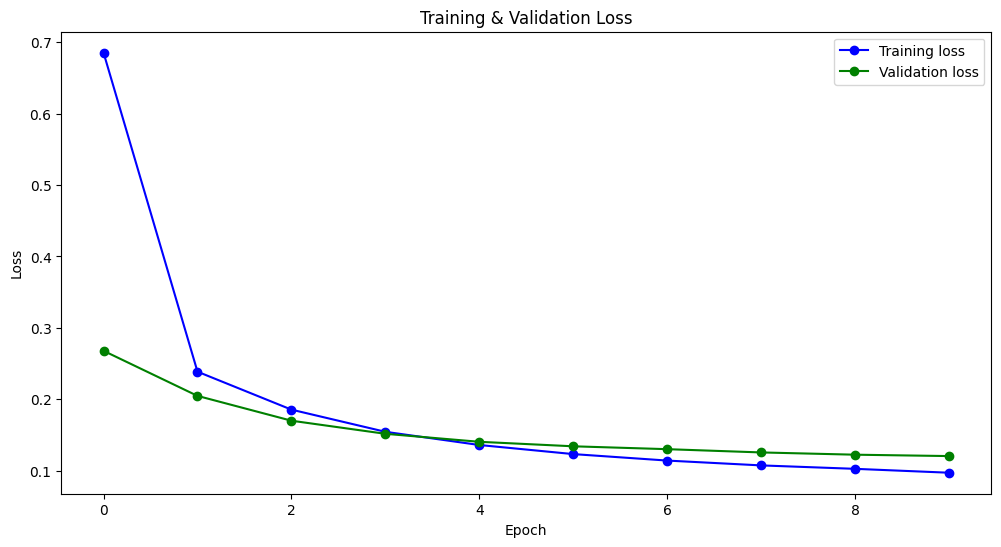

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, 'b-o', label="Training loss")
plt.plot(val_losses, 'g-o', label="Validation loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
save_path = '/content/gdrive/MyDrive/healthbot/gpt2'
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/gdrive/MyDrive/healthbot/gpt2/tokenizer_config.json',
 '/content/gdrive/MyDrive/healthbot/gpt2/special_tokens_map.json',
 '/content/gdrive/MyDrive/healthbot/gpt2/vocab.json',
 '/content/gdrive/MyDrive/healthbot/gpt2/merges.txt',
 '/content/gdrive/MyDrive/healthbot/gpt2/added_tokens.json')

In [ ]:
save_path = '/content/gdrive/MyDrive/healthbot/gpt2-new'
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/gdrive/MyDrive/healthbot/gpt2-new/tokenizer_config.json',
 '/content/gdrive/MyDrive/healthbot/gpt2-new/special_tokens_map.json',
 '/content/gdrive/MyDrive/healthbot/gpt2-new/vocab.json',
 '/content/gdrive/MyDrive/healthbot/gpt2-new/merges.txt',
 '/content/gdrive/MyDrive/healthbot/gpt2-new/added_tokens.json')

In [ ]:
def generate_answer(model, tokenizer, prompt, max_length=100):
    # Encode the prompt to tensor
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Generate the answer
    with torch.no_grad():
        output = model.generate(input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id)

    # Decode the generated text
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    return generated_text

In [ ]:
def generate_answer(model, tokenizer, prompt, max_length=300):
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Adjusting generation parameters
    output = model.generate(
        input_ids,
        max_length=max_length,
        pad_token_id=tokenizer.eos_token_id,
        temperature=0.7,  # Adjust for randomness
        top_p=0.9,        # Nucleus sampling
        no_repeat_ngram_size=2,  # Prevent repeating n-grams
        early_stopping=True,
        do_sample=True,
        num_beams=2
    )

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    # Optionally, remove the prompt from the output
    if generated_text.startswith(prompt):
        generated_text = generated_text[len(prompt):].strip()

    return generated_text


In [ ]:
print("Validation Data Examples:")
for i, item in enumerate(val_data[:5]):  # Adjust the number of examples as needed
    prompt = item['prompt']
    actual_answer = item['response']  # Assuming 'response' is the key for the actual answer
    generated_answer = generate_answer(model, tokenizer, prompt)

    print(f"\nExample {i+1}:")
    print("Prompt:", prompt)
    print("-"*100)
    print("Actual Answer:", actual_answer)
    print("-"*100)
    print("Generated Answer:", generated_answer)
    print("="*100)

Validation Data Examples:


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(



Example 1:
Prompt: Answer the following question:

What symptoms should raise a suspicion of back pain?
----------------------------------------------------------------------------------------------------
Actual Answer: three medicines for back pain include: Ibuprofen, Naproxen and Acetaminophen.
----------------------------------------------------------------------------------------------------
Generated Answer: one medicines for back problems include: Ibuprofen. symptoms of Back pain include Pain worsens with deep pain or discomfort, Pain radiating to arm, jaw, or back and Shortness of breath. Back Pain can be treated with rest and relaxation techniques. The pain can also be controlled with medications like Naproxen.

Example 2:
Prompt: Answer the following question:

What is diabetic neuropathy, and how does it manifest?
----------------------------------------------------------------------------------------------------
Actual Answer: Diabetic neuropathy is nerve damage caused by h

In [ ]:
print("Validation Data Examples:")
for i, item in enumerate(val_data[:2]):  # Adjust the number of examples as needed
    prompt = item['prompt']
    actual_answer = item['response']  # Assuming 'response' is the key for the actual answer
    generated_answer = generate_answer(model, tokenizer, prompt)

    print(f"\nExample {i+1}:")
    print("Prompt:", prompt)
    print("-"*100)
    print("Actual Answer:", actual_answer)
    print("-"*100)
    print("Generated Answer:", generated_answer)
    print("="*100)

Validation Data Examples:

Example 1:
Prompt: For the context of diarrhea, please consider the symptom and medicine information below:

Symptoms for diarrhea:
- Frequent loose, watery stools
- Abdominal cramps
- Bloating
- Nausea
- Urgent need to have a bowel movement
- Fever
- Blood or mucus in stool
- Dehydration
- Loss of appetite
- Weight loss

Medicines for diarrhea:
- Loperamide (Imodium)
- Bismuth subsalicylate (Pepto-Bismol)
- Antibiotics (if bacterial infection is present)
- Anti-diarrheal prescription medications
- Probiotics
- Rehydration solutions (e.g., oral rehydration salts)
- Anti-inflammatory medications (for specific causes)
- Dietary modifications (e.g., BRAT diet)
- Fluid replacement therapy
- Medications to treat underlying causes (e.g., antivirals for viral infections)

What symptoms typically signify the presence of diarrhea?

Please provide an answer to the following question:
--------------------------------------------------------------------------------------

In [ ]:
print("\nTest Data Examples:")
for i, item in enumerate(test_data[:5]):  # Adjust the number of examples as needed
    prompt = item['prompt']
    generated_answer = generate_answer(model, tokenizer, prompt)

    print(f"\nExample {i+1}:")
    print("Prompt:", prompt)
    print("-"*100)
    print("Generated Answer:", generated_answer)
    print("="*100)


Test Data Examples:

Example 1:
Prompt: Answer the following question:

When are antibiotics prescribed for congestion treatment?
----------------------------------------------------------------------------------------------------
Generated Answer: Antibiotics are prescribed to treat congestion caused by bacterial infections, but antibiotics are not recommended for severe congestion. symptoms of congestion include: Nasal congestion, Sinus pressure, Mucus buildup, Tingling or numbness. Antibiotic use is recommended if the underlying cause is a bacterial infection.Symptoms of severe or persistent congestion can include Nausea, Numbness or tingles,

Example 2:
Prompt: Answer the following question:

Which symptoms are most commonly associated with diabetes?
----------------------------------------------------------------------------------------------------
Generated Answer: one medicines for diabetes include: Insulin. symptoms of diabetes includes: Frequent urination, Increased thirst an

In [ ]:
!pip install nltk
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=9ae41f7a7ae8db14ecb323a6fefb1b9d55106f92766b6e73c9bf81067731729e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import nltk
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download("punkt")  # Download NLTK data for tokenization

# Function to calculate BLEU score
def calculate_bleu_score(actual, generated):
    actual_tokens = [nltk.word_tokenize(actual)]
    generated_tokens = nltk.word_tokenize(generated)

    # Apply smoothing function
    smoothing = SmoothingFunction()
    return sentence_bleu(actual_tokens, generated_tokens, smoothing_function=smoothing.method1)

# Function to calculate ROUGE score
def calculate_rouge_score(actual, generated):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(actual, generated)
    return scores['rougeL'].fmeasure

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train_bleu_scores = []
train_rouge_scores = []

val_bleu_scores = []
val_rouge_scores = []

# Calculate BLEU and ROUGE scores for train data
for item in train_data:
    prompt = item['prompt']
    actual_answer = item['response']
    generated_answer = generate_answer(model, tokenizer, prompt)

    # Calculate BLEU and ROUGE scores
    bleu_score = calculate_bleu_score(actual_answer, generated_answer)
    rouge_score = calculate_rouge_score(actual_answer, generated_answer)

    train_bleu_scores.append(bleu_score)
    train_rouge_scores.append(rouge_score)

# Calculate BLEU and ROUGE scores for validation data
for item in val_data:
    prompt = item['prompt']
    actual_answer = item['response']
    generated_answer = generate_answer(model, tokenizer, prompt)

    # Calculate BLEU and ROUGE scores
    bleu_score = calculate_bleu_score(actual_answer, generated_answer)
    rouge_score = calculate_rouge_score(actual_answer, generated_answer)

    val_bleu_scores.append(bleu_score)
    val_rouge_scores.append(rouge_score)

In [ ]:
# Calculate average BLEU and ROUGE scores for train and validation data
avg_train_bleu_score = sum(train_bleu_scores) / len(train_bleu_scores)
avg_train_rouge_score = sum(train_rouge_scores) / len(train_rouge_scores)

avg_val_bleu_score = sum(val_bleu_scores) / len(val_bleu_scores)
avg_val_rouge_score = sum(val_rouge_scores) / len(val_rouge_scores)

# Print the average scores
print(f"Average BLEU Score (Train): {avg_train_bleu_score:.4f}")
print(f"Average ROUGE Score (Train): {avg_train_rouge_score:.4f}")

print(f"Average BLEU Score (Validation): {avg_val_bleu_score:.4f}")
print(f"Average ROUGE Score (Validation): {avg_val_rouge_score:.4f}")

Average BLEU Score (Train): 0.0181
Average ROUGE Score (Train): 0.1715
Average BLEU Score (Validation): 0.0163
Average ROUGE Score (Validation): 0.1665


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from rouge_score import rouge_scorer

# Function to calculate ROUGE scores for a given n-gram
def calculate_rouge_n(actual, generated, n):
    scorer = rouge_scorer.RougeScorer([f'rouge{n}'], use_stemmer=True)
    scores = scorer.score(actual, generated)
    return scores[f'rouge{n}'].fmeasure

# Function to calculate average Cosine Similarity
def calculate_average_cosine_similarity(val_data):
    generated_responses = []
    actual_responses = []

    val_rouge_2_scores = []
    val_rouge_3_scores = []
    val_rouge_4_scores = []

    for item in val_data:
        prompt = item['prompt']
        actual_answer = item['response']
        generated_answer = generate_answer(model, tokenizer, prompt)

        # Calculate ROUGE-2, ROUGE-3, and ROUGE-4 scores
        rouge_2_score = calculate_rouge_n(actual_answer, generated_answer, 2)
        rouge_3_score = calculate_rouge_n(actual_answer, generated_answer, 3)
        rouge_4_score = calculate_rouge_n(actual_answer, generated_answer, 4)

        val_rouge_2_scores.append(rouge_2_score)
        val_rouge_3_scores.append(rouge_3_score)
        val_rouge_4_scores.append(rouge_4_score)

        generated_responses.append(generated_answer)
        actual_responses.append(actual_answer)

    # Vectorize the responses
    vectorizer = CountVectorizer().fit_transform(actual_responses + generated_responses)
    response_vectors = vectorizer.toarray()

    # Calculate the average Cosine Similarity
    num_actual_responses = len(actual_responses)
    num_generated_responses = len(generated_responses)
    similarities = cosine_similarity(response_vectors[:num_actual_responses], response_vectors[num_actual_responses:])
    average_cosine_similarity = np.mean(similarities)

    return average_cosine_similarity, val_rouge_2_scores, val_rouge_3_scores, val_rouge_4_scores

# Calculate average Cosine Similarity and ROUGE scores
average_cosine_similarity, val_rouge_2_scores, val_rouge_3_scores, val_rouge_4_scores = calculate_average_cosine_similarity(val_data)

# Print the results
print(f"Average Cosine Similarity between Generated and Actual Responses: {average_cosine_similarity:.4f}")
print(f"Average ROUGE-2 Score: {np.mean(val_rouge_2_scores):.4f}")
print(f"Average ROUGE-3 Score: {np.mean(val_rouge_3_scores):.4f}")
print(f"Average ROUGE-4 Score: {np.mean(val_rouge_4_scores):.4f}")

Average Cosine Similarity between Generated and Actual Responses: 0.2168
Average ROUGE-2 Score: 0.0833
Average ROUGE-3 Score: 0.0327
Average ROUGE-4 Score: 0.0133


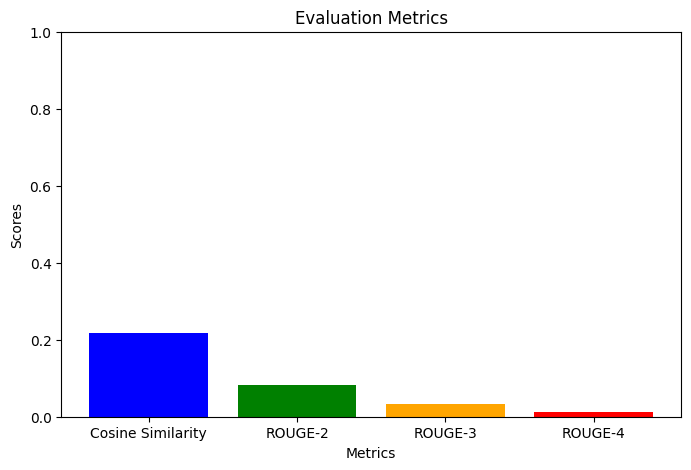

In [ ]:
# Metrics and their corresponding values
metrics = ['Cosine Similarity', 'ROUGE-2', 'ROUGE-3', 'ROUGE-4']
values = [average_cosine_similarity, np.mean(val_rouge_2_scores), np.mean(val_rouge_3_scores), np.mean(val_rouge_4_scores)]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)  # Set the y-axis limit to match the score range (0 to 1)
plt.show()

In [ ]:
from sentence_transformers import SentenceTransformer, util

st = SentenceTransformer("bert-base-nli-stsb-mean-tokens").to(device)
# Function to calculate semantic similarity
def calculate_semantic_similarity(val_data, model, device):
    similarities = []

    for item in val_data:
        prompt = item['prompt']
        actual_answer = item['response']
        generated_answer = generate_answer(model, tokenizer, prompt)

        # Encode sentences into embeddings on the GPU
        generated_embedding = st.encode(generated_answer, convert_to_tensor=True).to(device)
        reference_embedding = st.encode(actual_answer, convert_to_tensor=True).to(device)

        # Calculate cosine similarity on the GPU
        semantic_similarity = util.pytorch_cos_sim(generated_embedding, reference_embedding).item()
        similarities.append(semantic_similarity)

    return similarities

# Calculate semantic similarity for validation data
semantic_similarities = calculate_semantic_similarity(val_data, model, device)

# Print the semantic similarities
for idx, similarity in enumerate(semantic_similarities):
    print(f"Semantic Similarity for Example {idx + 1}: {similarity:.4f}")

.gitattributes:   0%|          | 0.00/391 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/630 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

Semantic Similarity for Example 1: 0.6740
Semantic Similarity for Example 2: 0.6760
Semantic Similarity for Example 3: 0.7714
Semantic Similarity for Example 4: 0.6653
Semantic Similarity for Example 5: 0.5409
Semantic Similarity for Example 6: 0.7619
Semantic Similarity for Example 7: 0.7497
Semantic Similarity for Example 8: 0.8374
Semantic Similarity for Example 9: 0.7486
Semantic Similarity for Example 10: 0.6854
Semantic Similarity for Example 11: 0.6540
Semantic Similarity for Example 12: 0.7491
Semantic Similarity for Example 13: 0.5595
Semantic Similarity for Example 14: 0.5917
Semantic Similarity for Example 15: 0.5962
Semantic Similarity for Example 16: 0.6912
Semantic Similarity for Example 17: 0.4453
Semantic Similarity for Example 18: 0.7794
Semantic Similarity for Example 19: 0.4620
Semantic Similarity for Example 20: 0.8054
Semantic Similarity for Example 21: 0.5863
Semantic Similarity for Example 22: 0.4284
Semantic Similarity for Example 23: 0.5375
Semantic Similarity 

In [ ]:
print(f"Average Semantic Similarity: {np.mean(semantic_similarities):.4f}")

Average Semantic Similarity: 0.6695


In [ ]:
file_path = "/content/gdrive/MyDrive/healthbot/semantic_similarities.pkl"

# Save semantic_similarities to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(semantic_similarities, file)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

responses = [item['response'] for item in val_data]

# Vectorize the responses
vectorizer = CountVectorizer().fit_transform(responses)
response_vectors = vectorizer.toarray()

# Calculate the average Cosine Similarity
average_cosine_similarity = np.mean(cosine_similarity(response_vectors))

print(f"Average Cosine Similarity: {average_cosine_similarity:.4f}")

In [ ]:
import nltk
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from nltk.chat.util import Chat, reflections


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)
model.eval()

# Pairs is a list of patterns and responses.
pairs = [
    [
        r"hi|hello|hey",
        ["Hello, I'm HealthBot. How can I assist you today?",]
    ],
    [
        r"what are the symptoms of (.*)",
        ["The symptoms of %1 include...", "Symptoms of %1 can range from...",]
    ],
    [
        r"how to treat (.*)",
        ["Treatment for %1 includes...",]
    ],
    [
        r"what is (.*) used for",
        ["%1 is used to treat...",]
    ],
    [
        r"quit",
        ["Goodbye! If you have more questions in the future, don't hesitate to ask.",]
    ],
]

# This is a simple reflection function that can be used to flip a few pronouns
# e.g. 'I am' becomes 'you are'
reflections = {
    "i am": "you are",
    "i was": "you were",
    "i": "you",
    "i'm": "you are",
    "i'd": "you would",
    "i've": "you have",
    "i'll": "you will",
    "my": "your",
    "you are": "I am",
    "you were": "I was",
    "you've": "I have",
    "you'll": "I will",
    "your": "my",
    "yours": "mine",
    "you": "me",
    "me": "you"
}

# Create your own Chatbot
health_bot = Chat(pairs, reflections)

def health_bot_chat():
    print("HealthBot\n---------")
    print("Hello! I'm HealthBot. I can help you with general health questions.\nType 'quit' to leave the chat.")

    while True:
        user_input = input("You: ")
        if user_input.lower() == 'quit':
            print("HealthBot: Goodbye!")
            break

        disease = preprocess_for_lstm(user_input)
        new_input = generate_prompt(user_input, disease, knowledge_graph)
        # Generate a response using your GPT-2 model
        response = generate_answer(model,tokenizer,new_input)
        print("HealthBot:", response)

# Uncomment the following line to run the chatbot
# health_bot_chat()


In [ ]:
health_bot_chat()

HealthBot
---------
Hello! I'm HealthBot. I can help you with general health questions.
Type 'quit' to leave the chat.
You: give me some medicines for fever
HealthBot: Fever is a common symptom of the gastrointestinal. symptoms of fever include: Abruption of gut flora, Abrupt bowel movement, Gas, Vibration, Diasthenia gravis, Heart attack. It is important to consult a healthcare provider for proper evaluation and diagnosis.
The medicines used in the treatment of heart attack include, Anticoagulants, Antiplatelet medications, Lifestyle changes, Dietary modifications, Fiber and Bismuth replacement therapy.
You: What are the medicines for diabetes?
HealthBot: The medicines used in diabetes include: Acetic acid diethylamide (e.g., sumatriptan), Oral antidiabetic drugs, Oral anti-diarrheal medications, Preventive medications (for chronic kidney disease), Anticoagulants (to treat underlying causes), Nasalist diethylate (containing fiber, zinc, and vitamin D). medicines are evaluated by the u

## Reinforcement Learning:

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

gpt2_model_path = '/content/gdrive/MyDrive/healthbot/gpt2-new'
# Load your fine-tuned GPT-2 model and tokenizer

tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_path)
model = GPT2LMHeadModel.from_pretrained(gpt2_model_path, output_hidden_states=True)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

In [ ]:
!pip install sentence-transformers

### using simple polocy network for reward model and total common words as reward function(loss as well)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

input_dim = train_inputs.shape[1]
output_dim = 256
embedding_dim = 128
hidden_dim = 128
learning_rate = 0.001

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        #print(embedded.shape)
        embedded = embedded.mean(dim=1)  # You can use mean pooling or another aggregation method
        x = torch.relu(self.fc1(embedded))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x


# Initialize the policy network
policy_net = PolicyNetwork(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

batch_size = 32
train_dataset = CustomDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CustomDataset(val_data)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = CustomDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def simple_reward_function(response, target):
    response_tokens = set(tuple(response.cpu().numpy()))  # Convert to tuple before creating a set
    target_tokens = set(tuple(target.cpu().numpy()))      # Convert to tuple before creating a set

    # Calculate the intersection of tokens
    intersection = response_tokens.intersection(target_tokens)

    # Reward based on the number of common tokens
    reward = len(intersection)

    return reward

In [ ]:
# Define optimizer and other hyperparameters
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

In [ ]:
num_epochs = 5
model.train()
train_rewards = []  # Store training rewards for plotting
val_rewards = []    # Store validation rewards for plotting

for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_val_reward = 0.0

    # Training loop
    for batch in train_dataloader:
        # Generate responses using the model
        generated_responses = []
        for prompt in batch['prompt']:
            generated_response = generate_answer(model, tokenizer, prompt, max_length=100)
            generated_responses.append(generated_response)

        # Tokenize the generated responses and target responses using your tokenizer
        tokenized_responses = [tokenizer.encode(response, return_tensors='pt', max_length=256, padding='max_length')[0].to(device) for response in generated_responses]
        tokenized_actual_resp = [tokenizer.encode(response, return_tensors='pt', max_length=256, padding='max_length')[0].to(device) for response in batch['response']]

        #print(tokenized_responses[0][0])

        # Calculate rewards using the simple_reward_function
        rewards = [simple_reward_function(response, target) for response, target in zip(tokenized_responses, tokenized_actual_resp)]

        rewards_tensor = torch.tensor(rewards, dtype=torch.float, requires_grad=True).to(device)

        # Calculate loss and update the model
        loss = torch.sum(rewards_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation during validation
        for batch in val_dataloader:
            # Generate responses using the model (similar to training loop)
            generated_responses = []
            for prompt in batch['prompt']:
                generated_response = generate_answer(model, tokenizer, prompt, max_length=100)
                generated_responses.append(generated_response)

            # Tokenize the generated responses and target responses using your tokenizer
            tokenized_responses = [tokenizer.encode(response, return_tensors='pt', max_length=256, padding='max_length')[0].to(device) for response in generated_responses]
            tokenized_actual_resp = [tokenizer.encode(response, return_tensors='pt', max_length=256, padding='max_length')[0].to(device) for response in batch['response']]

            # Calculate rewards using the simple_reward_function
            rewards = [simple_reward_function(response, target) for response, target in zip(tokenized_responses, tokenized_actual_resp)]

            # Accumulate validation rewards
            total_val_reward += sum(rewards)

    model.train()  # Set the model back to training mode
    # Calculate average training loss and validation reward for the epoch
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_reward = total_val_reward / len(val_dataloader)

    # Print and store results
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_train_loss}, Avg Val Reward: {avg_val_reward}")
    train_rewards.append(avg_train_loss)
    val_rewards.append(avg_val_reward)


### blue score as reward function:

In [ ]:
import nltk.translate.bleu_score as bleu
def calculate_bleu_score(generated_response, target_response):
    # Tokenize the generated and target responses
    generated_tokens = generated_response.split()
    target_tokens = target_response.split()

    # Calculate BLEU score
    bleu_score = bleu.sentence_bleu([target_tokens], generated_tokens)

    return bleu_score

In [ ]:
num_epochs = 10

train_rewards = []
val_rewards = []

# Training loop
for epoch in range(num_epochs):
    policy_net.train()
    total_train_reward = 0.0

    for batch in train_dataloader:
        # Tokenize the input sequences and responses using your tokenizer
        inputs1 = [tokenizer.encode(item, return_tensors='pt', max_length=256, padding='max_length').to(device) for item in batch['prompt']]
        responses1 = [tokenizer.encode(item, return_tensors='pt', max_length=256, padding='max_length').to(device) for item in batch['response']]

        inputs = [item for item in batch['prompt']]
        responses = [item  for item in batch['response']]

        # Convert tokenized inputs and responses to tensors
        input_tensors = torch.stack(inputs1, dim=0).squeeze().to(device)
        response_tensors = torch.stack(responses1, dim=0).squeeze().to(device)

        # Generate responses using GPT-2 model
        generated_responses = []
        for input_seq in inputs:
            #input_seq = input_seq.to(device)
            generated_response = generate_answer(model, tokenizer, input_seq, max_length=256)
            generated_responses.append(generated_response)
        #print(input_tensors.shape)
        # Calculate BLEU score rewards
        bleu_rewards = [sentence_bleu([response], generated, smoothing_function=None) for response, generated in zip(responses, generated_responses)]

        # Convert to tensor and calculate loss
        bleu_rewards_tensor = torch.tensor(bleu_rewards, dtype=torch.float32).to(device)

        #print(bleu_rewards_tensor.shape)
        #print(input_tensors.shape)
        loss = -torch.log(policy_net(input_tensors)) * bleu_rewards_tensor.reshape(batch_size,1)
        loss = loss.mean()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_reward += bleu_rewards_tensor.mean().item()

    # Calculate average training reward for this epoch
    avg_train_reward = total_train_reward / len(train_dataloader)
    train_rewards.append(avg_train_reward)

    # Validation phase
    policy_net.eval()
    total_val_reward = 0.0

    for val_batch in val_dataloader:
        # Tokenize validation data
        val_inputs1 = [tokenizer.encode(item, return_tensors='pt', max_length=256, padding='max_length').to(device) for item in val_batch['prompt']]
        val_responses1 = [tokenizer.encode(item, return_tensors='pt', max_length=256, padding='max_length').to(device) for item in val_batch['response']]

        val_inputs = [item for item in val_batch['prompt']]
        val_responses = [item  for item in val_batch['response']]

        # Generate responses using GPT-2 model
        val_generated_responses = []
        for val_input_seq in val_inputs:
            #val_input_seq = val_input_seq.to(device)
            val_generated_response = generate_answer(model, tokenizer, val_input_seq, max_length=256)
            val_generated_responses.append(val_generated_response)

        # Calculate BLEU score rewards for validation
        val_bleu_rewards = [sentence_bleu([val_response], val_generated, smoothing_function=None) for val_response, val_generated in zip(val_responses, val_generated_responses)]
        total_val_reward += np.mean(val_bleu_rewards)

    # Calculate average validation reward for this epoch
    avg_val_reward = total_val_reward / len(val_dataloader)
    val_rewards.append(avg_val_reward)

    # Print training and validation rewards for this epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Reward: {avg_train_reward:.4f}, Val Reward: {avg_val_reward:.4f}")


### using cosine similarity, jaccard similarity as reward function

In [ ]:
from sklearn.metrics import pairwise
import torch.nn.functional as F

# Function to calculate Jaccard similarity using PyTorch tensors
# Function to calculate Jaccard similarity between tokenized texts
def calculate_jaccard_similarity(text1, text2):
    # Join the token lists into single strings
    text1_str = ' '.join(text1)
    text2_str = ' '.join(text2)

    # Tokenize the joined strings to create sets of tokens
    tokens1 = set(tokenizer.tokenize(text1_str))
    tokens2 = set(tokenizer.tokenize(text2_str))

    # Calculate Jaccard similarity using sets
    intersection = len(tokens1.intersection(tokens2))
    union = len(tokens1.union(tokens2))

    # Calculate Jaccard similarity score
    jaccard_similarity = intersection / union

    return jaccard_similarity


# Custom reward function for batched responses and prompts
def reward_function(responses, prompts):
    # Initialize a list to store rewards for each batch
    batch_rewards = []

    for batch_responses, batch_prompts in zip(responses, prompts):
        # Tokenize responses and prompts and create sets of tokens for each batch
        tokenized_responses = [tokenizer.tokenize(response) for response in batch_responses]
        tokenized_prompts = [tokenizer.tokenize(prompt) for prompt in batch_prompts]

        # Calculate coherence scores for each response-prompt pair in the batch
        coherence_scores = [calculate_jaccard_similarity(tokens1, tokens2) for tokens1, tokens2 in zip(tokenized_responses, tokenized_prompts)]

        # You can define other reward components based on your criteria
        # For simplicity, we'll use just the coherence scores here
        rewards = coherence_scores

        # Append the rewards for this batch to the batch_rewards list
        batch_rewards.append(rewards)

    return batch_rewards

In [ ]:
# Function to calculate cosine similarity using PyTorch tensors
def calculate_cosine_similarity(text1, text2):
    # Tokenize text and convert to tensors
    inputs1 = tokenizer(text1, return_tensors='pt').to(device)
    inputs2 = tokenizer(text2, return_tensors='pt').to(device)

    # Get embeddings for tokens
    embeddings1 = model(**inputs1).last_hidden_state.mean(dim=1)
    embeddings2 = model(**inputs2).last_hidden_state.mean(dim=1)

    # Calculate cosine similarity
    cosine_similarity = F.cosine_similarity(embeddings1, embeddings2, dim=1)

    return cosine_similarity

# Custom reward function for batched responses and prompts
def reward_function(responses, prompts):
    # Initialize a list to store rewards for each batch
    batch_rewards = []

    for batch_responses, batch_prompts in zip(responses, prompts):
        # Calculate cosine similarity for each response-prompt pair in the batch
        similarities = [calculate_cosine_similarity(response, prompt) for response, prompt in zip(batch_responses, batch_prompts)]

        # You can define other reward components based on your criteria
        # For simplicity, we'll use just the cosine similarities here
        rewards = similarities.tolist()

        # Append the rewards for this batch to the batch_rewards list
        batch_rewards.append(rewards)

    return batch_rewards

In [ ]:
# Custom reward function for batched responses and prompts
def reward_function(responses, prompts):
    # Initialize a list to store rewards for each batch
    batch_rewards = []

    for batch_responses, batch_prompts in zip(responses, prompts):
        # Tokenize responses and prompts and create sets of tokens for each batch
        tokenized_responses = [tokenizer.tokenize(response) for response in batch_responses]
        tokenized_prompts = [tokenizer.tokenize(prompt) for prompt in batch_prompts]

        # Convert tokenized responses and prompts to tensors on the GPU
        tensor_responses = [tokenizer.encode(tokens, return_tensors='pt').to('cuda') for tokens in tokenized_responses]
        tensor_prompts = [tokenizer.encode(tokens, return_tensors='pt').to('cuda') for tokens in tokenized_prompts]

        # Concatenate the tensors along the batch dimension
        tensor_responses = torch.cat(tensor_responses, dim=0)
        tensor_prompts = torch.cat(tensor_prompts, dim=0)

        # Generate model outputs for responses and prompts
        with torch.no_grad():
            response_outputs = model(tensor_responses).last_hidden_state
            prompt_outputs = model(tensor_prompts).last_hidden_state

        # Calculate cosine similarity for each response-prompt pair in the batch
        similarities = [F.cosine_similarity(response.mean(dim=1), prompt.mean(dim=1), dim=-1) for response, prompt in zip(response_outputs, prompt_outputs)]

        # You can define other reward components based on your criteria
        # For simplicity, we'll use just the cosine similarities here
        rewards = similarities

        # Append the rewards for this batch to the batch_rewards list
        batch_rewards.append(rewards)

    return batch_rewards

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
#from sentence_transformers import SentenceTransformer, util
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch.nn.functional as F

# Load a pre-trained sentence embeddings model
#sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def get_embedding_gpt2(text, model, tokenizer):
      # Ensure the model's device
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        # Get the last hidden state
        last_hidden_state = outputs.hidden_states[-1]

    # Mean pooling
    embedding = last_hidden_state.mean(dim=1)
    return embedding


def reward_function_gpt2(generated_response, actual_response, model, tokenizer):
    generated_embedding = get_embedding_gpt2(generated_response, model, tokenizer)
    actual_embedding = get_embedding_gpt2(actual_response, model, tokenizer)

    # Ensure that tensors are on the same device (GPU)
    generated_embedding = generated_embedding.to(model.device)
    actual_embedding = actual_embedding.to(model.device)
    #print(generated_embedding)
    #print(actual_embedding.shape)
    # Calculate cosine similarity on GPU
    reward = F.cosine_similarity(generated_embedding, actual_embedding, dim=1)
    return reward.item()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)
batch_size = 8  # Adjust as needed
num_epochs = 3

In [ ]:
# Lists to store training and validation reward scores
train_rewards_history = []
val_rewards_history = []

# Training loop
for epoch in range(num_epochs):
    train_rewards = []  # To store rewards for each batch
    val_rewards = []    # To store rewards for each batch

    # Training
    for i in range(0, len(train_data), batch_size):
        batch_examples = train_data[i:i + batch_size]
        batch_prompts = [example['prompt'] for example in batch_examples]

        # Generate responses for the batch
        batch_responses = [generate_answer(model, tokenizer, prompt) for prompt in batch_prompts]

        # Calculate rewards using the custom reward function
        rewards = reward_function(batch_responses, batch_prompts)

        # Expand the list of rewards and compute the mean reward
        expanded_rewards = [reward for sublist in rewards for reward in sublist]
        mean_reward = sum(expanded_rewards) / len(expanded_rewards)

        # Append mean reward to the list
        train_rewards.append(mean_reward)

        mean_reward = torch.tensor(mean_reward, device=model.device, requires_grad=True)
        # Update the model using the mean reward as the loss
        loss = -mean_reward  # Negative mean reward for maximization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation
    for i in range(0, len(val_data), batch_size):
        batch_examples = val_data[i:i + batch_size]
        batch_prompts = [example['prompt'] for example in batch_examples]

        # Generate responses for the batch
        batch_responses = [generate_answer(model, tokenizer, prompt) for prompt in batch_prompts]

        # Calculate rewards using the custom reward function
        rewards = reward_function(batch_responses, batch_prompts)

        # Expand the list of rewards and compute the mean reward
        expanded_rewards = [reward for sublist in rewards for reward in sublist]
        mean_reward = sum(expanded_rewards) / len(expanded_rewards)

        # Append mean reward to the list
        val_rewards.append(mean_reward)

    # Calculate average reward scores for the epoch
    avg_train_reward = sum(train_rewards) / len(train_rewards)
    avg_val_reward = sum(val_rewards) / len(val_rewards)

    # Print reward scores for the current epoch
    print(f'Epoch {epoch + 1}:')
    print(f'Train Reward Score: {avg_train_reward:.4f}')
    print(f'Validation Reward Score: {avg_val_reward:.4f}')

    # Append reward scores to history lists
    train_rewards_history.append(avg_train_reward)
    val_rewards_history.append(avg_val_reward)

In [ ]:
# Plotting the reward graph
plt.figure(figsize=(10, 5))
plt.plot(train_rewards, label='Training Reward')
plt.plot(val_rewards, label='Validation Reward')
plt.xlabel('Epochs')
plt.ylabel('Average Reward')
plt.title('Training and Validation Rewards')
plt.legend()
plt.show()

In [ ]:
save_path = '/content/gdrive/MyDrive/healthbot/gpt2-rl'
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

### Using general training for reinforcement learning

## With Flan-T5

In [ ]:
lstm_w_attn_path = '/content/gdrive/MyDrive/healthbot/LSTMwA/lstm_w_attn_full_final.pt'
tokenizer_path = '/content/gdrive/MyDrive/healthbot/LSTMwA/'
lstm_w_attn = torch.load(lstm_w_attn_path)
lstm_tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
lstm_w_attn = lstm_w_attn.to(device)
lstm_w_attn.eval()

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")


all_prompts = []
for i in range(len(inp_queries)):
  prompts = f"""
              Answer the following question and give valid response
              Question: {inp_queries[i]}
              Answer: {inp_responses[i]}
              """
  all_prompts.append(prompts)

#input_ids = tokenizer(all_prompts, return_tensors="pt").input_ids

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


In [ ]:
lstm_w_attn_path = '/content/gdrive/MyDrive/healthbot/LSTMwA/lstm_w_attn_full_final.pt'
tokenizer_path = '/content/gdrive/MyDrive/healthbot/LSTMwA/'
lstm_w_attn = torch.load(lstm_w_attn_path)
lstm_tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
lstm_w_attn = lstm_w_attn.to(device)
lstm_w_attn.eval()

prepro_txts = preprocess(inp_queries)
ip_ids, attn_mask = ic_preprocess(prepro_txts, lbls=None)
ip_ids = ip_ids.to(device)
attn_mask = attn_mask.to(device)

with torch.no_grad():
    outputs = lstm_w_attn(ip_ids)#, attention_mask=attn_mask)
    _, predicts = torch.max(outputs.data, 1)

inverted_label_dict = {v: k for k, v in label_mapping.items()}

if isinstance(predicts, torch.Tensor):
    predicts = predicts.cpu().numpy()  # If predicts is a tensor
predicts = [int(label) for label in predicts]  # Convert to int if they are numpy types or Python tensors

# Map the predicted labels to string labels
ic_diseases = [inverted_label_dict[label] for label in predicts]

In [ ]:
if isinstance(predicts, torch.Tensor):
    predicts = predicts.cpu().numpy()  # If predicts is a tensor
predicts = [int(label) for label in predicts]  # Convert to int if they are numpy types or Python tensors

# Map the predicted labels to string labels
ic_diseases = [inverted_label_dict[label] for label in predicts]

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")


all_prompts = []
for i in range(len(inp_queries)):
  symptoms = knowledge_graph[ic_diseases[i]]['symptoms'][:5]
  medicines = knowledge_graph[ic_diseases[i]]['medicines'][:5]
  prompts = f"""
              Answer the following question and give valid response.
              Also consider these information while answering.
              Information: Symptoms and Medicines for {ic_diseases[i]} in the question are
                           Symptoms - {symptoms} and Medicines - {medicines}
              Question: {inp_queries[i]}
              Answer: {inp_responses[i]}
              """
  all_prompts.append(prompts)

#input_ids = tokenizer(all_prompts, return_tensors="pt").input_ids

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, tokenizer, texts, max_length=512):
        self.tokenizer = tokenizer
        self.inputs = texts
        self.max_length = max_length

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = self.inputs[idx]
        inputs = self.tokenizer.encode_plus(
            input_text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation=True
        )
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long)
        }

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts = train_test_split(all_prompts, test_size=0.1)  # 10% for validation

train_dataset = CustomDataset(tokenizer, train_texts)
val_dataset = CustomDataset(tokenizer, val_texts)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
save_path = '/content/gdrive/MyDrive/healthbot/flan-t5-base'

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained(save_path)
model = T5ForConditionalGeneration.from_pretrained(save_path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
save_path = '/content/gdrive/MyDrive/healthbot/flan-t5-base-new'

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained(save_path)
model = T5ForConditionalGeneration.from_pretrained(save_path)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

In [ ]:
from transformers import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3  # You can adjust this

### With LoRA

In [ ]:
class LoRALayer(nn.Module):
    def __init__(self, original_layer, rank):
        super(LoRALayer, self).__init__()
        self.rank = rank
        self.original_layer = nn.Linear(original_layer.in_features, original_layer.out_features, bias=False)
        self.original_layer.weight = original_layer.weight  # Copy original weights
        self.B = nn.Parameter(torch.randn(original_layer.out_features, rank))
        self.A = nn.Parameter(torch.randn(rank, original_layer.in_features))
        if original_layer.bias is not None:
            self.bias = original_layer.bias
        else:
            self.bias = None

    def forward(self, x):
        W_lora = self.original_layer.weight + torch.matmul(self.B, self.A)
        return nn.functional.linear(x, W_lora, self.bias)


In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

In [ ]:
def apply_lora_to_t5_block(block, rank):
    for i, layer in enumerate(block.children()):
        for name, sub_layer in layer.named_children():
            if isinstance(sub_layer, nn.Linear):
                setattr(layer, name, LoRALayer(sub_layer, rank=rank))

rank = 8  # Define the rank for LoRA

# Apply LoRA to T5 model's encoder and decoder
for block in model.encoder.block:
    apply_lora_to_t5_block(block, rank)
for block in model.decoder.block:
    apply_lora_to_t5_block(block, rank)


In [ ]:
lora_learning_rate = 1e-3
base_learning_rate = 1e-5

# Collect LoRA and base model parameters
lora_params = [p for p in model.parameters() if hasattr(p, 'B') or hasattr(p, 'A')]
base_params = [p for p in model.parameters() if not (hasattr(p, 'B') or hasattr(p, 'A'))]

optimizer = AdamW([
    {'params': lora_params, 'lr': lora_learning_rate},
    {'params': base_params, 'lr': base_learning_rate}
])

In [ ]:
#without LoRA
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")


In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#with LoRA
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

train_losses = []
val_losses = []
num_epochs = 5  # Define the number of epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):  # Replace train_loader with your DataLoader
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:  # Replace val_loader with your DataLoader
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")


In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
save_path = '/content/gdrive/MyDrive/healthbot/flan-t5-small'
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

In [ ]:
save_path = '/content/gdrive/MyDrive/healthbot/flan-t5-base-new'
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

In [ ]:
save_path = '/content/gdrive/MyDrive/healthbot/flan-t5-base-lora'
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

In [ ]:
from PIL import Image
from IPython.display import display

# Path to your image
image_path = '/content/gdrive/MyDrive/healthbot/flan-t5-base-loss-3e.png'

# Open and display the image
image = Image.open(image_path)
display(image)

In [ ]:
path = "/content/gdrive/MyDrive/healthbot/"
file_name = 'input_queries5.pkl'
with open(path + file_name , 'rb') as file:
    test_queries1 = pickle.load(file)

In [ ]:
test_inputs1 = []
for disease, dicts in test_queries1.items():
    for key,lists in dicts.items():
      for queries in lists:
        test_inputs1.append(queries)

In [ ]:
prepro_txts1 = preprocess(test_inputs1)
ip_ids1, attn_mask1 = ic_preprocess(prepro_txts1, lbls=None)
ip_ids1 = ip_ids1.to(device)
attn_mask1 = attn_mask1.to(device)

with torch.no_grad():
    outputs1 = lstm_w_attn(ip_ids1)#, attention_mask=attn_mask)
    _, predicts1 = torch.max(outputs1.data, 1)



if isinstance(predicts1, torch.Tensor):
    predicts1 = predicts1.cpu().numpy()  # If predicts is a tensor
predicts1 = [int(label) for label in predicts1]  # Convert to int if they are numpy types or Python tensors

# Map the predicted labels to string labels
ic_diseases1 = [inverted_label_dict[label] for label in predicts1]

In [ ]:
test_prompts1 = []
for i in range(len(test_inputs1)):
  symptoms1 = knowledge_graph[ic_diseases1[i]]['symptoms'][:5]
  medicines1 = knowledge_graph[ic_diseases1[i]]['medicines'][:5]
  prompts1 = f"""
              Answer the following question and give valid response.
              Also consider these information while answering.
              Information: Symptoms and Medicines for {ic_diseases1[i]} in the question are
                           Symptoms - {symptoms1} and Medicines - {medicines1}
              Question: {test_inputs1[i]}
              Answer:
              """
  test_prompts1.append(prompts1)

In [ ]:
test_prompts = []
for i in range(len(test_inputs1)):
  prompts = f"""
              Answer the following question and give valid response
              Question: {test_inputs1[i]}
              Answer:
             """
  test_prompts.append(prompts)

In [ ]:
import random
random.shuffle(test_prompts)

In [ ]:
test_encodings = tokenizer(test_prompts, padding=True, truncation=True, return_tensors="pt")

In [ ]:
test_encodings = {k: v.to(device) for k, v in test_encodings.items()}

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.eval()

def generate_responses_in_chunks(model, tokenizer, test_encodings, chunk_size=20):
    # Split the test_encodings into smaller chunks
    input_ids_chunks = test_encodings['input_ids'].split(chunk_size)
    attention_mask_chunks = test_encodings['attention_mask'].split(chunk_size)

    generated_responses = []
    for i in range(len(input_ids_chunks)):
        with torch.no_grad():
            chunk_ids = input_ids_chunks[i].to(device)
            chunk_mask = attention_mask_chunks[i].to(device)

            # Generate responses for the chunk
            generated_ids = model.generate(
                input_ids=chunk_ids,
                attention_mask=chunk_mask,
                max_length=100
            )

            # Decode the generated ids
            for gen_id in generated_ids:
                response = tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
                generated_responses.append(response)

    return generated_responses

# Assuming test_encodings is already defined
generated_responses = generate_responses_in_chunks(model, tokenizer, test_encodings)


In [ ]:
for i, response in enumerate(generated_responses[:5]):
    print(f"{test_prompts[i]}")
    print(f"{response}\n")

In [ ]:
#with LoRA,
for i, response in enumerate(generated_responses[0:5]):
    print(f"{test_prompts[i]}")
    print(f"{response}\n")

In [ ]:
ex = "whar are the symptoms of diarrhea?"

input_text1 = f"""
              Answer the following question and give valid response
              Question: {ex}
              Answer:
              """
input_ids1 = tokenizer(input_text1, truncation=True, return_tensors="pt")

outputs = model.generate(input_ids1['input_ids'].to(device),
                         attention_mask=input_ids1['attention_mask'].to(device),
                         max_length=50
                         #num_beams=3,    # Optional, for beam search
                         #temperature=1.0)
                         )
print(tokenizer.decode(outputs[0]))

## Interface